# W207 Summer 2018 Final Project 
---

**Authors:** Divya Gorantla, Ram Iyer, Tiffany Jaya, Steve Sanders <br/>
**Date:** 5 August 2018

---

## Table of Contents

1. [Introduction](#introduction)
2. [Exploratory Data Analysis](#eda)
  1. [Load libraries](#load-libraries)
  2. [Load data](#load-data)
  3. [Identify the train labels](#identify-the-train-labels)
  4. [Identify the train features](#identify-the-train-features)
  5. [Address concerns about the datasets](#address-concerns-about-the-datasets)
  6. [Univariate analysis](#univariate-analysis)
  7. [Bivariate analysis](#bivariate-analysis)
3. [Feature Engineering](#feature-engineering)
  1. [Features not included](#features-not-included)
  2. [Define the baseline test](#baseline-test)
  3. [Define functions to be used in the pipeline](#fe-functions)
  4. [Define features to be used in the pipeline](#fe-features)
4. [Final Model](#final-model)
5. [References](#references)
6. [Appendix](#appendix)
---

<a id='introduction'/>

## Introduction

Our goal in this project is to classify an observed 30 x 30 meter land into one of the seven forest cover types found in the Roosevelt National Forest of Northern Colarado: 

| Forest Cover Type  | Tree   | Leaf  | 
| ------------------ |:------:| -----:| 
| Spruce/Fir         | <img src='./img/spruce-tree.jpg' alt='Spruce tree' height='65px' width='65px'/><br /><img src='./img/fir-tree.jpg' alt='Fir tree' height='65px' width='65px'/> | <img src='./img/spruce.jpg' alt='Spruce leaf' height='65px' width='65px'/><br /><img src='./img/fir.jpg' alt='Fir leaf' height='65px' width='65px'/> | 
| Lodgepole Pine     | <img src='./img/lodgepole-pine-tree.jpg' alt='Lodgepole Pine tree' height='65px' width='65px'/> | <img src='./img/lodgepole-pine.jpg' alt='Lodgepole Pine leaf' height='65px' width='65px'/> | 
| Ponderosa Pine     | <img src='./img/ponderosa-pine-tree.jpg' alt='Ponderosa Pine tree' height='65px' width='65px'/> | <img src='./img/ponderosa-pine.jpg' alt='Ponderosa Pine leaf' height='65px' width='65px'/> |
| Cottonwood/Willow  | <img src='./img/cottonwood-tree.jpg' alt='Cottonwood tree' height='65px' width='65px'/><br /><img src='./img/willow-tree.jpg' alt='Willow tree' height='65px' width='65px'/> | <img src='./img/cottonwood.jpg' alt='Cottonwood leaf' height='65px' width='65px'/><br /><img src='./img/willow.jpg' alt='Willow leaf' height='65px' width='65px'/> |
| Aspen              | <img src='./img/aspen-tree.jpg' alt='Aspen tree' height='65px' width='65px'/> | <img src='./img/aspen.jpg' alt='Aspen leaf' height='65px' width='65px'/> | 
| Douglas-Fir        | <img src='./img/douglas-fir-tree.jpg' alt='Douglas-Fir tree' height='65px' width='65px'/> | <img src='./img/douglas-fir.jpg' alt='Douglas-Fir leaf' height='65px' width='65px'/> | 
| Krummholz <br />(stunted trees) | <img src='./img/krummholz-tree.jpg' alt='Krummholz tree' height='65px' width='65px'/> | |

Fortunately for us, 15,120 of these observations have been labeled to their respective forest cover types. We can then use this labeled dataset to train several different models and compare which model can best accurately classify the forest cover type based on just the cartographic information. 

What we have found is that stacking multiple classifier models performs the best with an accuracy score of 80.71%.  


<a id='eda'/>

## Exploratory Data Analysis

All cartographic information that we use as features to determine the forest cover type has been collected by the US Geological Survey (USGS) and US Forest Service (USFS). The associating labels were derived separately by the USFS Region 2 Resource Information System. We download them from the Kaggle website via the Kaggle API. 

<a id='load-libraries'/>

### Load libraries

In [352]:
# general libraries
import itertools
import pandas as pd
import numpy as np

# plot libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# preprocessing (aka feature engineering)
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

# model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# model definition
from sklearn import svm as SVM
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# ensemble
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# ensemble: boosting algorithms
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# model metrics
from sklearn.metrics import accuracy_score

# for plotting
from pandas.plotting import parallel_coordinates
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
from PIL import Image

# define the random_state
random_state = 7

<a id='load-data'/>

### Load data

We used the Kaggle API to download the data directly from the Kaggle website. 

To use the Kaggle API, please follow these instructions:

1. Login to your Kaggle account
2. Select 'My account'
3. Select 'Create New API Token'
4. Place the token 'kaggle.json' into ~/.kaggle

We decided to comment out the code relating to the use of Kaggle API since it was tested in a MAC OS and cannot guarantee reliability in other OS.

In [2]:
# install the Kaggle API library
#!pip install kaggle

# download each ZIP file from the Kaggle website via the Kaggle API
#!kaggle competitions download -c forest-cover-type-prediction -p ./data 

# define each downloaded file
TRAIN_FILENAME = 'train.csv'
TEST_FILENAME = 'test.csv'
SAMPLE_SUBMISSION_FILENAME = 'sampleSubmission.csv'

# define where the downloaded file will be stored
DATAPATH = './data/'

# unzip the files and load them as a panda DataFrame
def get_data(filename, unzip=False):
    '''Read CSV file (unzip or not) into a dataframe'''
    if unzip:
        zippath = DATAPATH + filename + '.zip'
        return pd.read_csv(zippath, compression='zip', header=0, sep=',', quotechar='"', index_col='Id')
    
    filepath = DATAPATH + filename
    return pd.read_csv(filepath, header=0, sep=',', quotechar='"', index_col='Id')

train = get_data(TRAIN_FILENAME, unzip=False)
test = get_data(TEST_FILENAME, unzip=False)
sample = get_data(SAMPLE_SUBMISSION_FILENAME, unzip=False)

In [3]:
# define the data
train_data = train.drop('Cover_Type', axis=1)
test_data = test

# define the labels
train_labels = train['Cover_Type']

In [4]:
# define additional labels, not defined in the dataset
cover_types = sorted(pd.unique(train['Cover_Type'])) # 1-7
cover_labels = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
wilderness_types = list(range(1,5)) # 1-4
wilderness_labels = ['Rawah', 'Neota', 'Comanche', 'Cache la Poudre']
soil_types = list(range(1,41)) # 1-40
soil_labels = ['Cathedral family', 
               'Vanet', 
               'Haploborolis', 
               'Ratake family',
               'Vanet family',
               'Vanet - Wetmore families',
               'Gothic family',
               'Supervisor',
               'Troutville family',
               'Bullwark - Catamount families',
               'Bullwark - Catamount families',
               'Legault family',
               'Catamount family',
               'Pachic Argiborolis',
               '',
               'Cryaquolis',
               'Gateview family',
               'Rogert family',
               'Typic Cryaquolis',
               'Typic Cryaquepts',
               'Typic Cryaquolls',
               'Leighcan family',
               'Leighcan family',
               'Leighcan family',
               'Leighcan family',
               'Granile',
               'Leighcan family',
               'Leighcan family',
               'Como - Legault families',
               'Como family',
               'Leighcan - Catamount families',
               'Catamount family',
               'Leighcan - Catamount families',
               'Cryorthents',
               'Cryumbrepts',
               'Bross family',
               'Cryumbrepts',
               'Leighcan - Moran families',
               'Moran family - Cryorthents',
               'Moran family - Cryorthents'
              ]
soil_descriptions = ['Rock outcrop complex, extremely stony',
                     'Ratake families complex, very stony',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, stony',
                     '',
                     'Limber families complex',
                     'very stony',
                     'Rock outcrop complex, rubbly',
                     'Rock land complex, rubbly',
                     ' Rock land complex, stony',
                     'Rock land - Bullwark family complex, rubbly',
                     'Aquolis complex',
                     '',
                     'Cryoborolis complex',
                     'Cryaquolis complex',
                     'very stony',
                     'Borohemists complex',
                     'Typic Cryaquolls complex',
                     'Leighcan family, till substratum complex',
                     'till substratum, extremely bouldery',
                     'till substratum, extremely bouldery',
                     'extremely stony',
                     'warm, extremely stony',
                     'Catamount families complex, very stony',
                     'Rock outcrop complex, extremely stony',
                     'Rock outcrop complex, extremely stony',
                     'complex, extremely stony',
                     'Rock land - Legault family complex, extremely stony',
                     'complex, extremely stony',
                     'Rock outcrop - Leighcan family complex, extremely stony',
                     'Rock outcrop complex, extremely stony',
                     'Rock land complex, extremely stony',
                     'Rock outcrop - Cryaquepts complex',
                     'Rock land - Cryumbrepts complex, extremely stony',
                     'Cryumbrepts - Cryorthents complex, extremely stony',
                     'Cryaquolls complex, extremely stony',
                     'Cryorthents - Leighcan family complex, extremely stony',
                     'Cryorthents - Rock land complex, extremely stony'
                    ]
numerical_feature_labels = [ 'Elevation (in meters)',
                             'Aspect (in degrees)',
                             'Slope (in degrees)',
                             'Horizontal Distance To Hydrology',
                             'Vertical Distance To Hydrology',
                             'Horizontal Distance To Roadways',
                             'Hillshade 9am (0 to 255 index)',
                             'Hillshade 12pm (0 to 255 index)',
                             'Hillshade 3pm  (0 to 255 index)',
                             'Horizontal Distance To Fire Points',
                           ]

In [5]:
# create different categories of vars so we can do appropriate transformations
soil_vars        = ["Soil_Type" + str(i) for i in range(1,41)]
wilderness_vars  = ["Wilderness_Area" + str(i) for i in range(1,5)]
categorical_vars = soil_vars + wilderness_vars
numerical_vars   = train_data.columns[:10]
hillshade_vars   = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']
distance_vars    = ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
                    'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']
degree_vars      = ['Aspect','Slope']

In [6]:
# create a lookup table to easily map features to descriptions
lookup_cover_labels      = dict(zip(cover_types,cover_labels))
lookup_soil_labels       = dict(zip(soil_vars,soil_labels))
lookup_wilderness_labels = dict(zip(wilderness_vars,wilderness_labels))
lookup_numerical_labels  = dict(zip(numerical_vars,numerical_feature_labels))

['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']


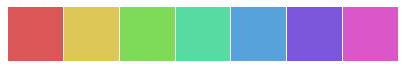

In [7]:
# specify the color to use for the train labels
rgb_values = sns.hls_palette(7, 10).as_hex()
# print out each associating label's color
sns.palplot(sns.color_palette(rgb_values))
print(cover_labels)

<a id='identify-the-train-labels'/>

### Identify the train labels

There are 2,160 observations for each of the seven forest cover types. The classes are represented equally, which is great news, because we do not have to concern ourselves with misleading classification accuracy, a common problem that plagues an imbalanced dataset.

1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: Cover_Type, dtype: int64

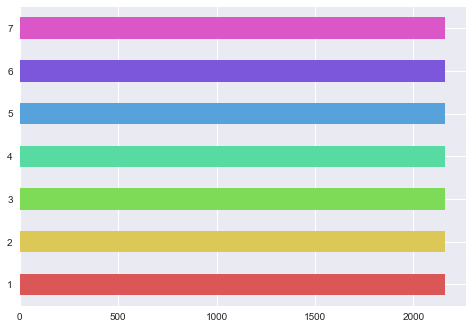

In [8]:
train_labels.value_counts().sort_values(ascending=False).plot(kind='barh', color=rgb_values)
train_labels.value_counts().sort_values(ascending=False)

<a id='identify-the-train-features'/>

### Identify the train features

In the train dataset, there are 15,120 observations with 54 features. 

In [9]:
print(train_data.shape)
train_data.columns

(15120, 54)


Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In the test dataset, there are 565,892 observations which includes the 54 features found in the train dataset. In other words, we have validated that the train dataset is a good dataset to use as it shares the same cartographic information as the test dataset.

In [10]:
print(test.shape)
test.columns

(565892, 54)


Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

Looking at the features, it is interesting to note that we do not see longitude and latitude values, which means we cannot validate the cartographic information to the actual geographic location. The 54 features are summarized in the following table below:

| Name                               | Measurement     | Description                                               |
| ----------------------------------:| ---------------:| ---------------------------------------------------------:|
| Elevation                          | meters          | Height above sea level                                    |
| Aspect                             | degrees azimuth | Compass direction that a slope faces<br/>0: North, 90: East, 180: South, 270: West<br/>Potential influence on temperature and soil | 
| Slope                              | degrees         | Degree of incline of a surface<br/>In other words, maximum rate of change of elevation<br/>Has gradient and aspect as components                                                     | 
| Horizontal_Distance_To_Hydrology   | meters          | Horizontal Distance to the nearest surface water features | 
| Vertical_Distance_To_Hydrology     | meters          | Vertical Distance to the nearest surface water features   | 
| Horizontal_Distance_To_Roadways    | meters          | Horizontal distance to the nearest roadway                | 
| Horizontal_Distance_To_Fire_Points | meters          | Horizontal distance to the nearest wildfire ignition points | 
| Hillshade_9am                      | 0 (dark) to 255 (light) | Hillshade index at 9 AM, summer solstice | 
| Hillshade_Noon                     | 0 (dark) to 255 (light) | Hillshade index at 12 PM, summer solstice | 
| Hillshade_3pm                      | 0 (dark) to 255 (light) | Hillshade index at 3 PM, summer solstice | 
| Wilderness_Area (4 binary columns) | 0 (absent) or 1 (present) | Wilderness area designation<br/>1: Rawah, 2: Neota, 3: Comanche, 4: Cache la Poudre | 
| Soil_Type (40 binary columns)      | 0 (absent) or 1 (present) | Soil type designation |



<a id='address-concerns-about-the-datasets' />

### Address concerns about the datasets

#### 1. train data's size < test data's size

In order for us to confidently apply the datasets onto the models, we first take a look at the size of the training set and compare it to the test set. Unfortunately, the number of observations in the training set is substantially fewer than the number of observations in the test set. With less training data, the parameter estimates that we determined from our models can have greater variance in the accuracy prediction. On a positive note, if we are more concerned about estimating the actual error of our model, having a bigger test set can help in achieving this. For this reason, we consider it to be not a substantial issue to use the training dataset despite the size difference.

In [11]:
# compare the relative sizes of the train and test dataset
train_size = train_data.shape[0]
test_size = test_data.shape[0]
total_size = train_size + test_size
print('percentage of train dataset: {:.2f}%'.format(train_size/total_size*100))
print('percentage of test dataset: {:.2f}%'.format(test_size/total_size*100))

percentage of train dataset: 2.60%
percentage of test dataset: 97.40%


#### 2. Missing Values

There are no apparent missing values. Further analysis are needed (via looking at the plot) if missing values existed in the form of 0's or other similar numbers. As we will later learned, hillshade has several missing values in the forms of 0's.

In [12]:
print('any missing values? {}'.format(train.isnull().sum().sum() > 0))

any missing values? False


#### 3. Outliers

It is not surprising that forests with krummholz cover type have outliers in several cartographic features. The reason being is that krummholz is not specific to a certain type of tree. They occur as a result of trees being stunted down from wind blows occuring commonly in the harsh conditions of the mountains. 

Another facet that is interesting to note is that nearly all of the forest cover types have outliers in their distances to hydrology. Without having an expert in this field that can guide us whether or not these outliers are reasonable, we cannot conclusively dismiss these outliers.

Lastly, we noticed several outliers in the lower end of Hillshade_9am and Hillshade_Noon. Hillshade is shades of gray computed using elevation, slope, aspect, and azimuth (angular direction of the sun). It is limited to the color range of white (0) to black (255). For this reason, it is not surprising that any lighter or darker shade of gray would fall outside the 0-255 spectrum, causing outliers to occur. We will take this into consideration during our feature engineering stage.

In [13]:
train_data.describe()

Elevation        Aspect         Slope  \
count  15120.000000  15120.000000  15120.000000   
mean    2749.322553    156.676653     16.501587   
std      417.678187    110.085801      8.453927   
min     1863.000000      0.000000      0.000000   
25%     2376.000000     65.000000     10.000000   
50%     2752.000000    126.000000     15.000000   
75%     3104.000000    261.000000     22.000000   
max     3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000                        5.000000   
50%                          180.000000                       32.000000   
75%                          330.000000                       79.000000   
max                         1343.000000                      554.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                     15120.000000   15120.000000    15120.000000   
mean                       1714.023214     212.704299      218.965608   
std                        1325.066358      30.561287       22.801966   
min                           0.000000       0.000000       99.000000   
25%                         764.000000     196.000000      207.000000   
50%                        1316.000000     220.000000      223.000000   
75%                        2270.000000     235.000000      235.000000   
max                        6890.000000     254.000000      254.000000   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points      ...       \
count   15120.000000                        15120.000000      ...        
mean      135.091997                         1511.147288      ...        
std        45.895189                         1099.936493      ...        
min         0.000000                            0.000000      ...        
25%       106.000000                          730.000000      ...        
50%       138.000000                         1256.000000      ...        
75%       167.000000                         1988.250000      ...        
max       248.000000                         6993.000000      ...        

        Soil_Type31   Soil_Type32   Soil_Type33   Soil_Type34   Soil_Type35  \
count  15120.000000  15120.000000  15120.000000  15120.000000  15120.000000   
mean       0.021958      0.045635      0.040741      0.001455      0.006746   
std        0.146550      0.208699      0.197696      0.038118      0.081859   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        Soil_Type36   Soil_Type37   Soil_Type38   Soil_Type39   Soil_Type40  
count  15120.000000  15120.000000  15120.000000  15120.000000  15120.000000  
mean       0.000661      0.002249      0.048148      0.043452      0.030357  
std        0.025710      0.047368      0.214086      0.203880      0.171574  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000      1.000000      1.000000  

[8 rows x 54 columns]

In [14]:
# use modified z-score if the dataset is small, which is not necessary in our case
# standard z-score: use standard deviation
# modified z-score: use mean absolute deviation

def outliers_standard_z_score(ys):
    threshold = 3
    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

def outliers_modified_z_score(ys):
    threshold = 3.5
    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)

print('Number of outliers using standard Z-score')
print('-' * 45)
for feature_name in numerical_vars:
    print('{}: {}'.format(feature_name, len(outliers_standard_z_score(train_data[feature_name])[0])))
print('\n')    
print('Number of outliers using modified Z-score')
print('-' * 45)
for feature_name in numerical_vars:
    print('{}: {}'.format(feature_name, len(outliers_modified_z_score(train_data[feature_name])[0])))

Number of outliers using standard Z-score
---------------------------------------------
Elevation: 0
Aspect: 0
Slope: 39
Horizontal_Distance_To_Hydrology: 285
Vertical_Distance_To_Hydrology: 213
Horizontal_Distance_To_Roadways: 155
Hillshade_9am: 160
Hillshade_Noon: 129
Hillshade_3pm: 0
Horizontal_Distance_To_Fire_Points: 331


Number of outliers using modified Z-score
---------------------------------------------
Elevation: 0
Aspect: 0
Slope: 11
Horizontal_Distance_To_Hydrology: 359
Vertical_Distance_To_Hydrology: 491
Horizontal_Distance_To_Roadways: 584
Hillshade_9am: 229
Hillshade_Noon: 129
Hillshade_3pm: 0
Horizontal_Distance_To_Fire_Points: 413


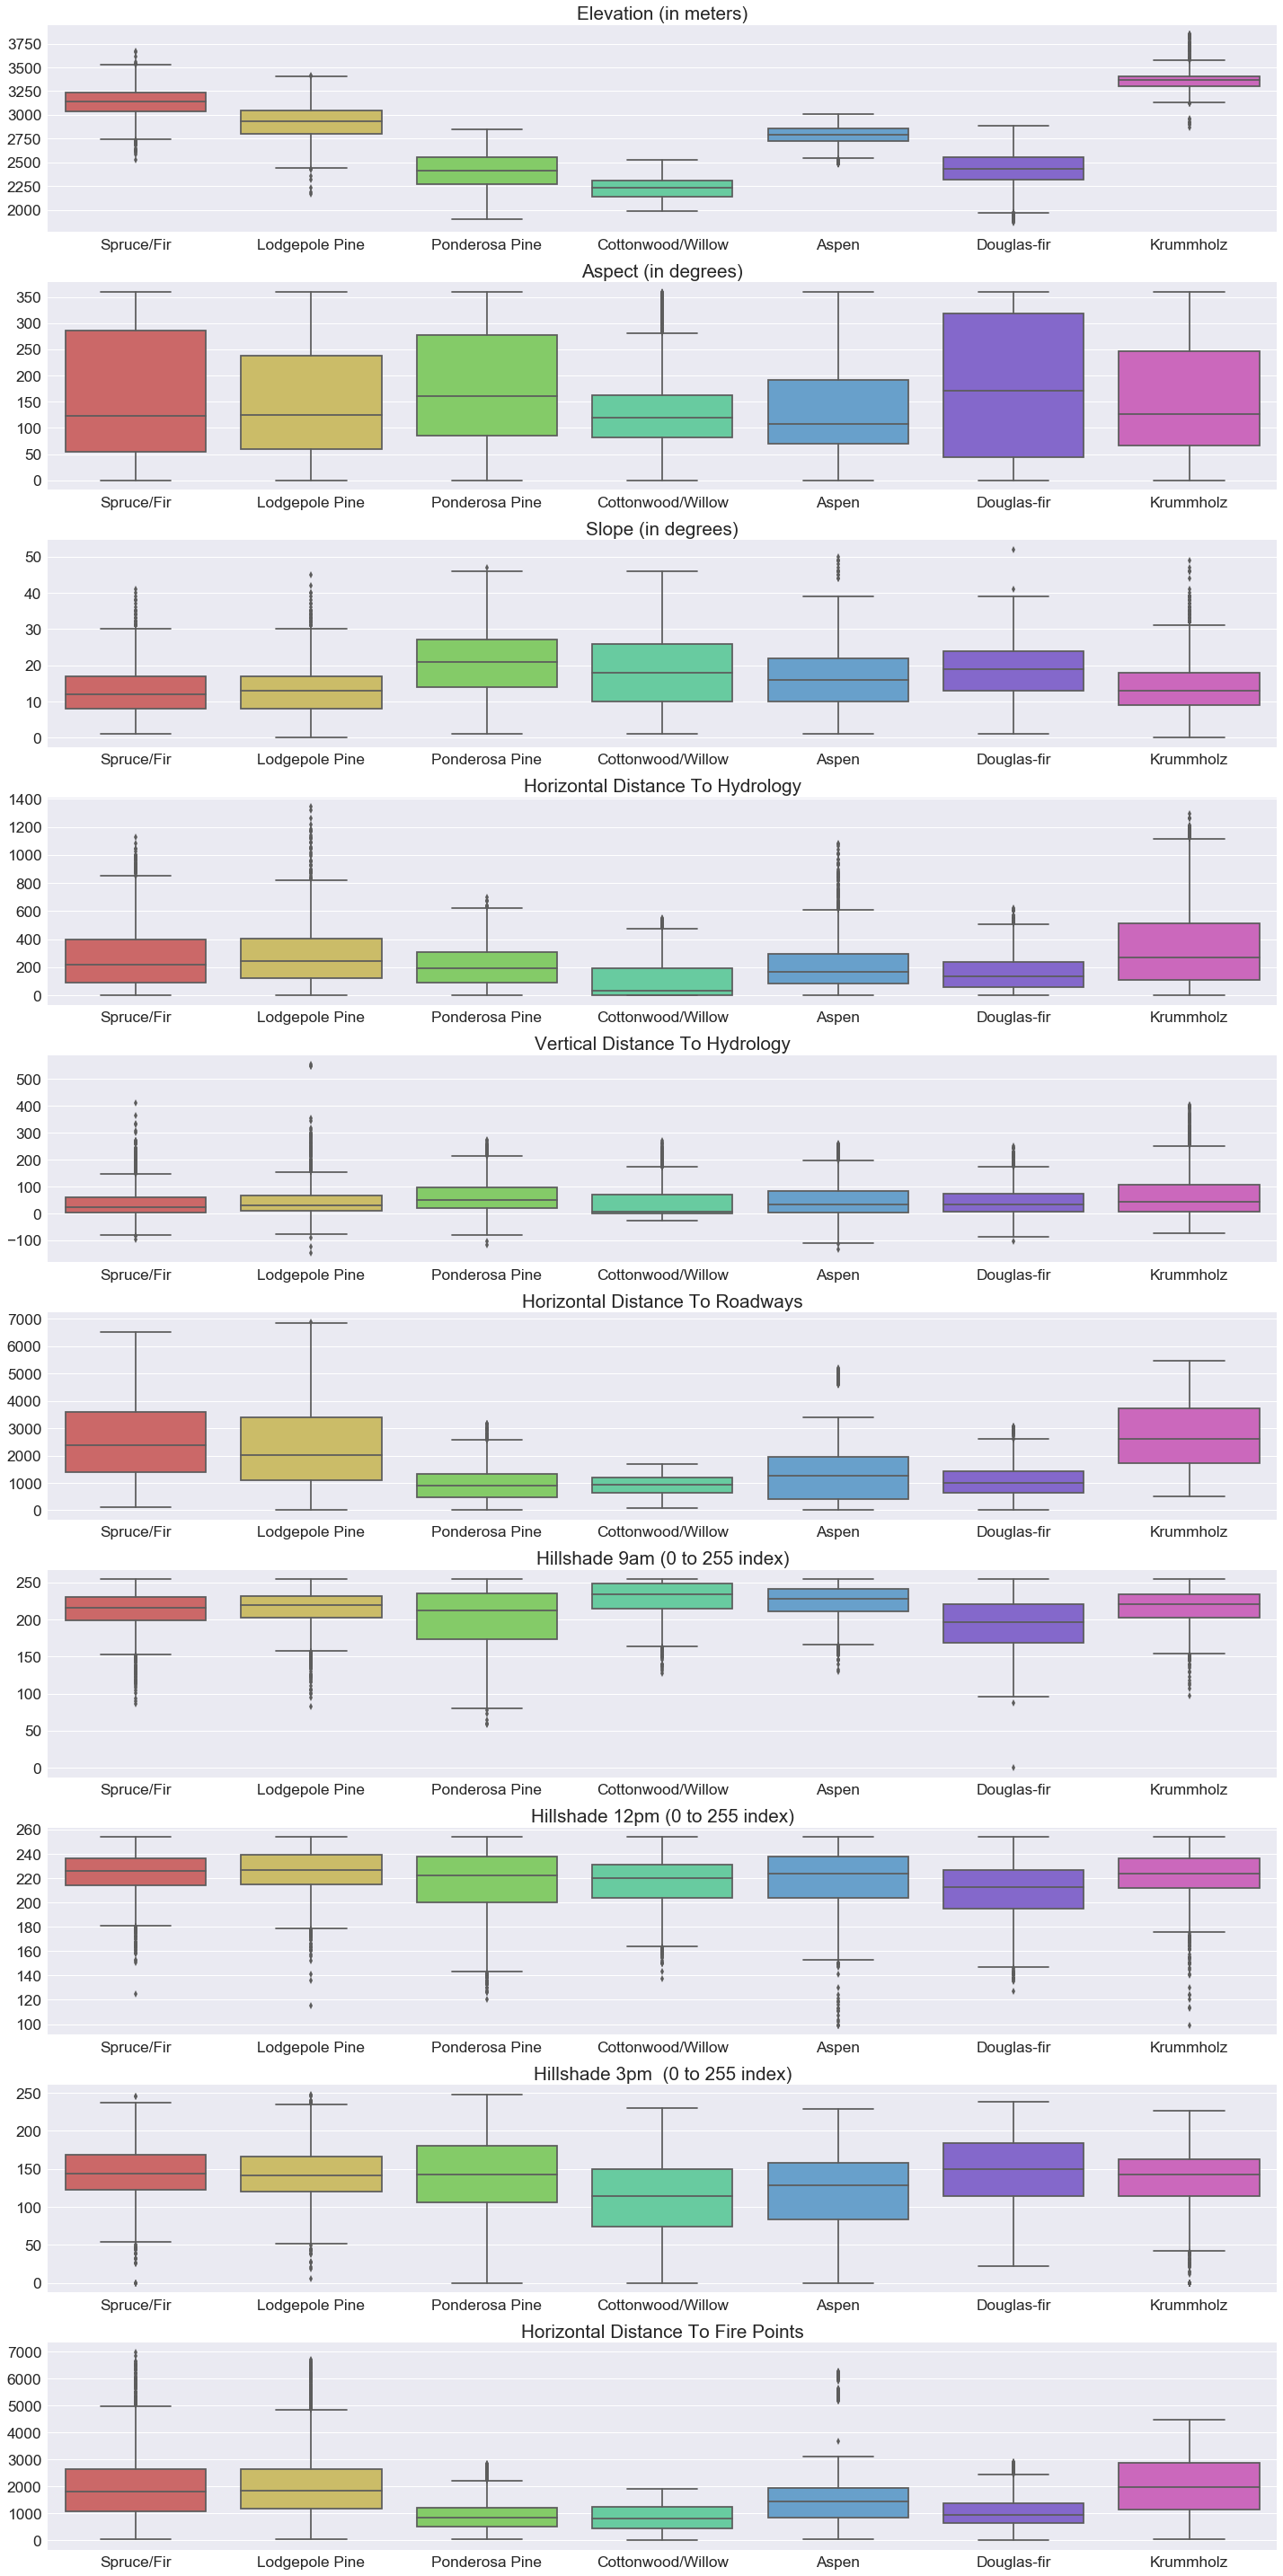

In [15]:
def plot_boxplot(feature_name, description, axis):
    sns.boxplot(y=train_data[feature_name], x=train_labels, palette=rgb_values, ax=axis)
    # adding swarmplot slows down the plotting process
    #sns.swarmplot(y=train_data[feature_name], x=train_labels, color='black', alpha=0.75, ax=axis)
    axis.set_title(description, fontsize='xx-large')
    axis.set_xlabel('')
    axis.set_ylabel('')
    axis.set_xticklabels(cover_labels, fontsize='x-large')
    for tick in axis.yaxis.get_major_ticks():
        tick.label.set_fontsize('x-large')

ncols = 1
nrows = len(numerical_vars)
fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize = (20,40))

for plot_index, feature_name in enumerate(numerical_vars):
    plot_boxplot(feature_name, lookup_numerical_labels[feature_name], axes[plot_index])
    
fig.tight_layout()
plt.show()

<a id='univariate-analysis' />

### Univariate Analysis

By overlaying the histogram for each forest cover type, we can immediately see that elevation plays a great role in identifying the cover types because the cover types rarely overlaps each other compare to the other features.

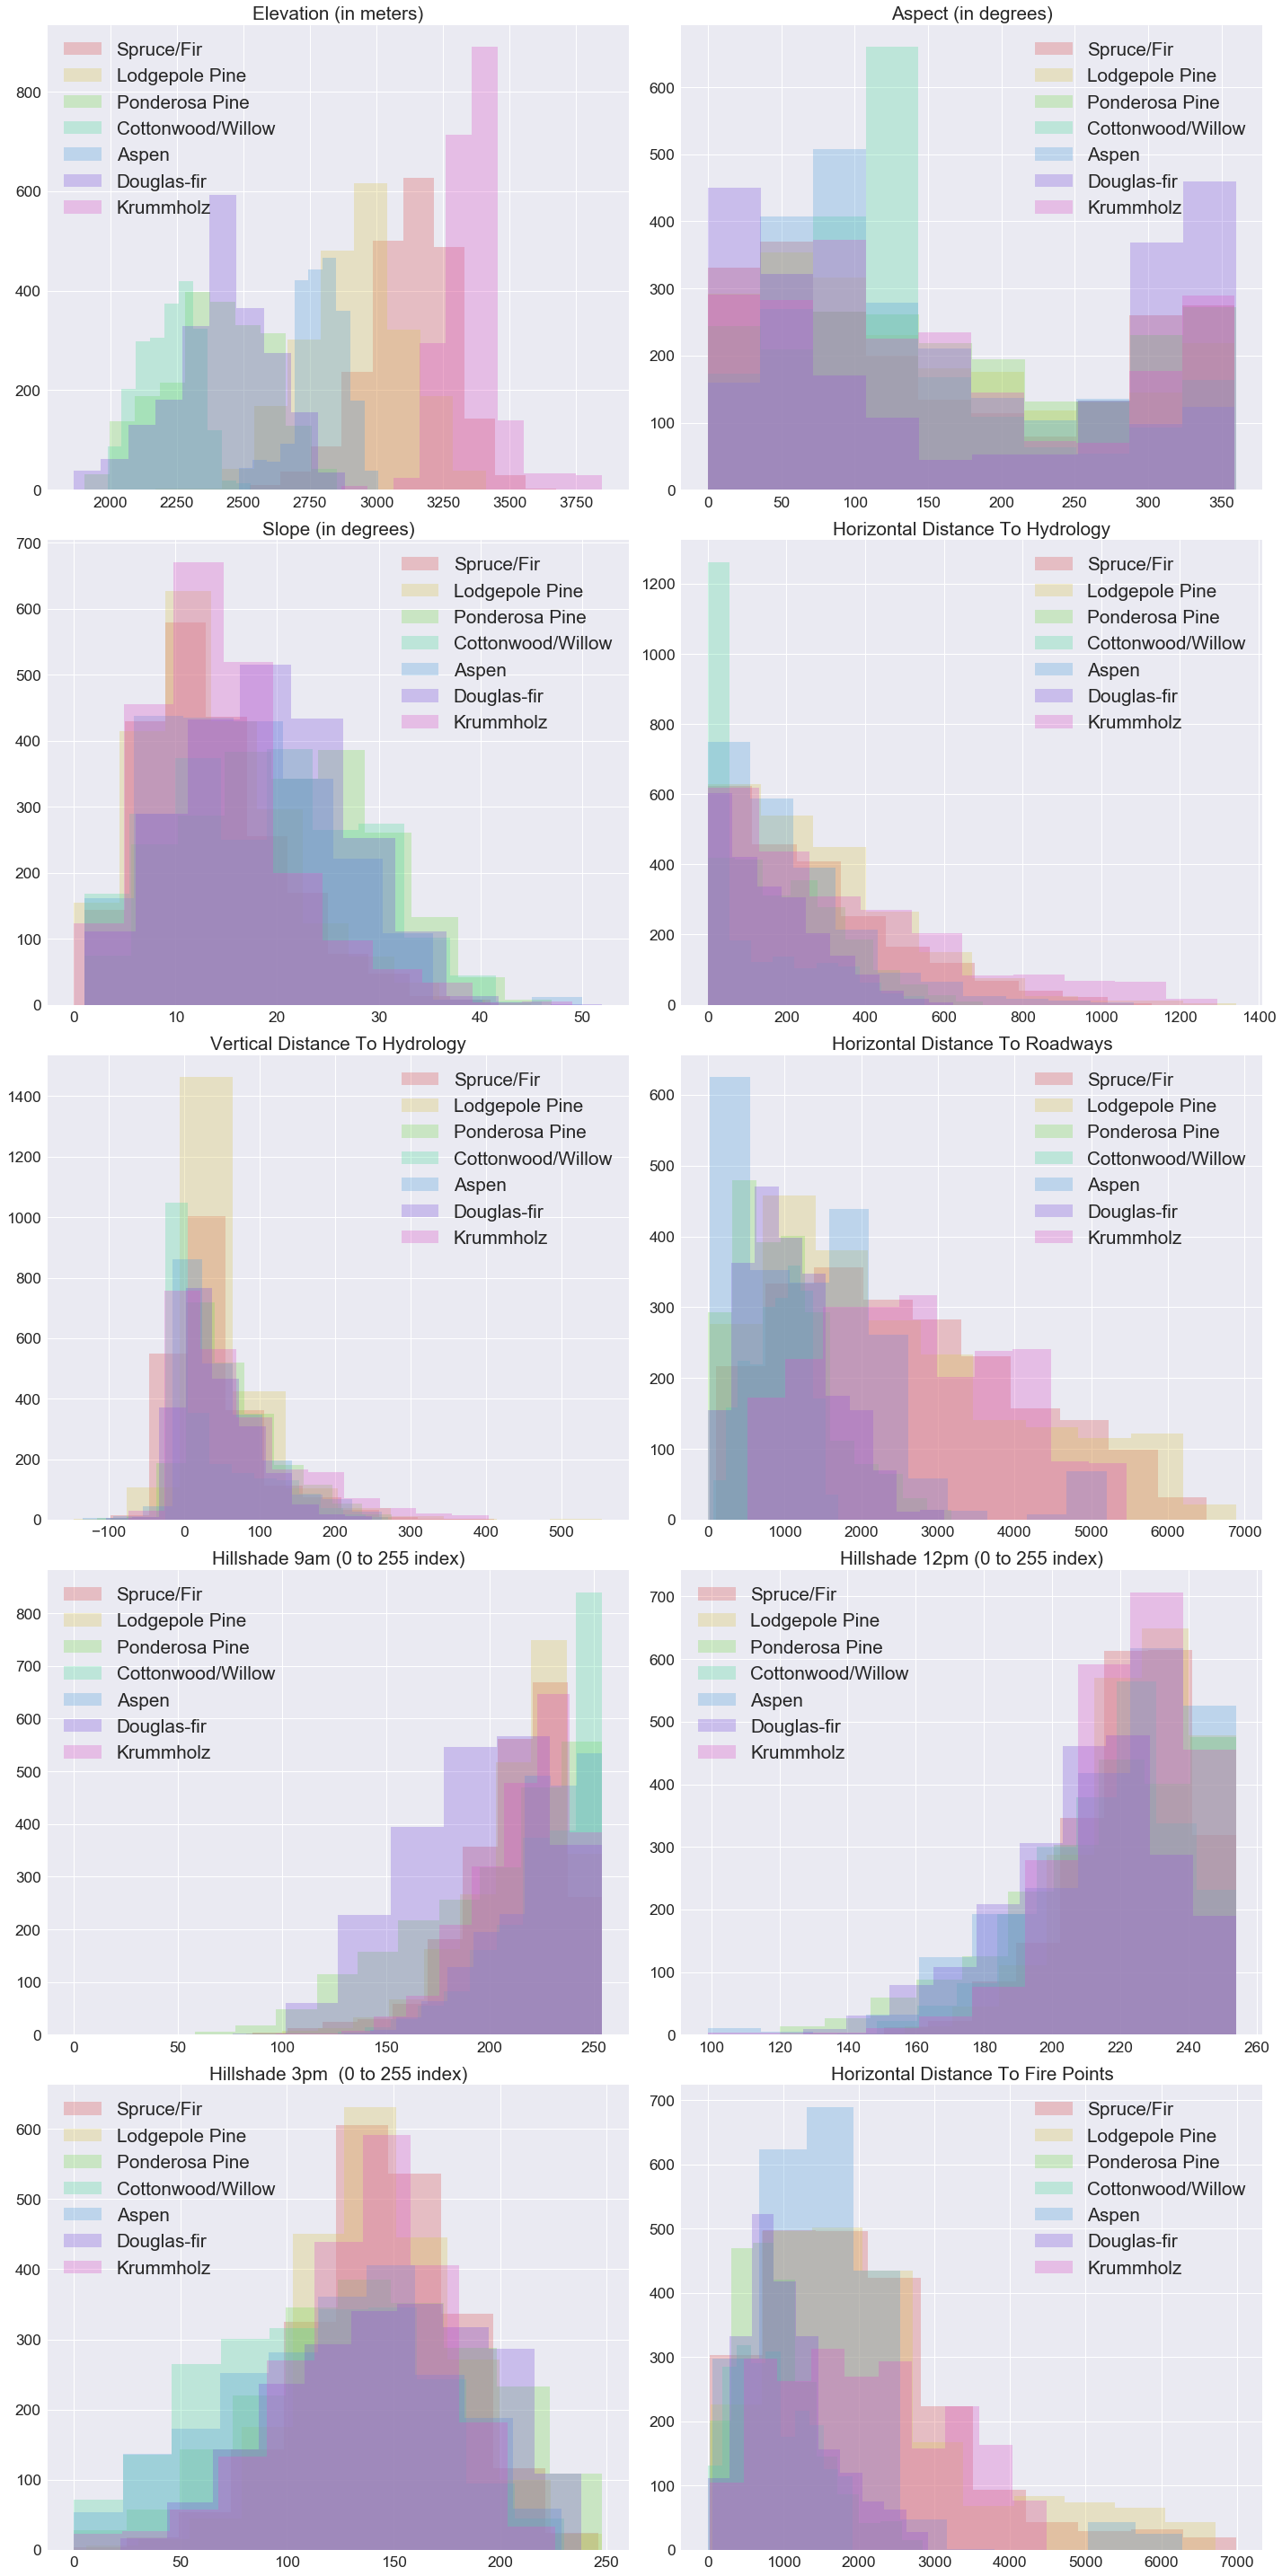

In [16]:
def plot_histogram (feature_name, description, axis):
    for (label, data), color in zip(train.groupby('Cover_Type')[feature_name], rgb_values):
        data.hist(alpha=0.3, ax=axis, color=color)
        axis.set_title(description, fontsize='xx-large')
        axis.legend(labels=cover_labels, fontsize='xx-large')
        for tick in axis.xaxis.get_major_ticks():
            tick.label.set_fontsize('x-large')
        for tick in axis.yaxis.get_major_ticks():
            tick.label.set_fontsize('x-large')

# plot non-binary features
ncols = 2
nrows = len(numerical_vars)//2
fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize = (20,40))

for plot_index, feature_name in enumerate(numerical_vars):
    row_index = plot_index//2
    col_index = plot_index - (2 * row_index)
    plot_histogram(feature_name, lookup_numerical_labels[feature_name], axes[row_index, col_index])

fig.tight_layout()
plt.show()

#### Elevation

From the graph shown above, it appears that the cover types most commonly found at the high altitude is Krummholz followed by the following cover types found in descending order of elevation:

* Krummholz
* Spruce/Fir
* Lodgepole Pine
* Aspen
* Ponderosa Pine
* Douglas-fir
* Cottonwood/Willow

#### Aspect

Aspect is another feature that plays an important role in the growth of the trees. The direction where the slope faces affects the amount of sunlight a tree receives. For example, in northern latitudes, forests with a southerly aspect tends to be warmer and drier than their neighbors with a northerly aspect. We can see this clearly from the heatmap below that the majority of the trees have higher concentration in aspects that are in the north-west direction, in particular the Douglas-Fir tree. The only exception to the norm is Cottonwood/Willow whose preference lies in aspects that are in the south-east direction. 

From the polar plot, it reconfirms that elevation plays a greater role in identifying the cover type. There's a cover type in almost every aspect (360 degree).

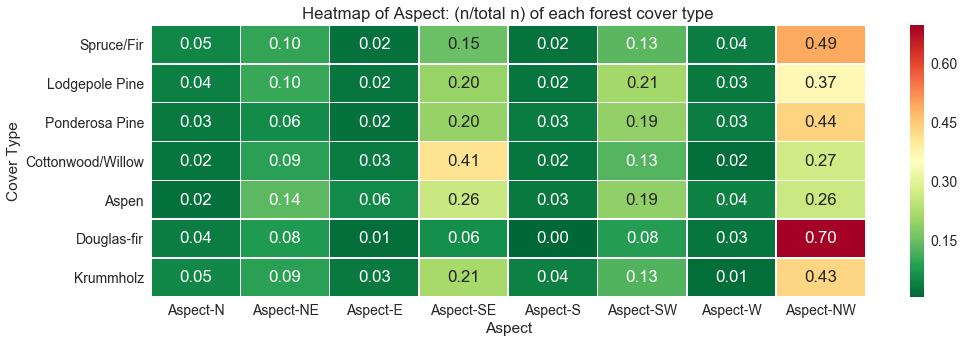

In [17]:
# North: [354+3/8, 5+5/8)
# NE:    [5+5/8, 84+3/8)
# East:  [84+3/8, 95+5/8)
# SE:    [95+5/8, 174+3/8)
# South: [174+3/8, 185+5/8)
# SW:    [185+5/8, 264+3/8)
# West:  [264+3/8, 275+5/8)
# NW:    [275+5/8, 354+3/8)
compass_range = [0, 5+5/8, 84+3/8, 95+5/8, 174+3/8, 185+5/8, 264+3/8, 275+5/8, 354+3/8, 360]

a = train[['Aspect', 'Cover_Type']] \
    .groupby(['Cover_Type', pd.cut(train['Aspect'], compass_range)]) \
    .sum() \
    .unstack()    
a.rename(columns={a.columns[0][1]: 'N1',
                  a.columns[1][1]: 'NE',
                  a.columns[2][1]: 'E',
                  a.columns[3][1]: 'SE',
                  a.columns[4][1]: 'S',
                  a.columns[5][1]: 'SW',
                  a.columns[6][1]: 'W',
                  a.columns[7][1]: 'NW',
                  a.columns[8][1]: 'N2'
                 }, inplace=True)
# add the columns N1 and N2 together to form N
a.insert(loc=0, column=('Aspect', 'N'), value=a[('Aspect', 'N1')] + a[('Aspect', 'N2')])
a.drop([('Aspect', 'N1'), ('Aspect', 'N2')], axis=1, inplace=True)
# divide by the total number of each row
a = a.div(a.sum(axis=1), 0)
# plot a heatmap 
plt.figure(figsize=(16,5))
sns.set(font_scale=1.4)
fig = sns.heatmap(a, annot=True, cmap='RdYlGn_r', fmt='.2f', linewidth=0.5, yticklabels=cover_labels)
fig.set_xlabel('Aspect')
fig.set_ylabel('Cover Type')
plt.title('Heatmap of Aspect: (n/total n) of each forest cover type')
plt.show()

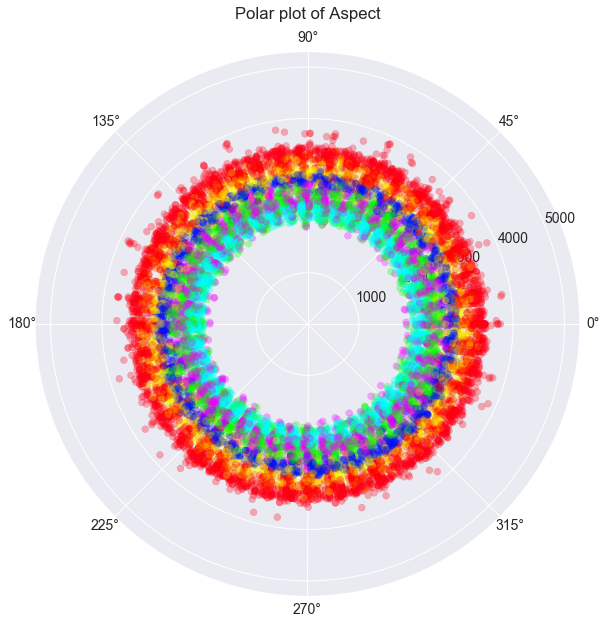

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax = plt.subplot(111, projection='polar')
ax.scatter(train_data['Aspect'], train_data['Elevation'], c=train_labels, cmap='hsv', alpha=0.3)
plt.title('Polar plot of Aspect');

['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']


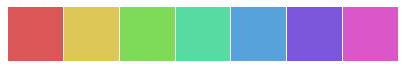

In [19]:
# specify legend
rgb_values = sns.hls_palette(7, 10).as_hex()
sns.palplot(sns.color_palette(rgb_values))
print(cover_labels)

#### Slope

Slope indicates the steepness of the terrain where the forests lie. Like aspect, slope affects the growth of trees. As can be seen from the graph below, the steepness of the average slope for each cover type are ranked in the following descending order (from the highest to the lowest):

* Ponderosa Pine
* Douglas-Fir
* Cottonwood/Willow
* Aspen
* Krummholz
* Lodgepole Pine
* Spruce/Fir

Text(0.5,1,'')

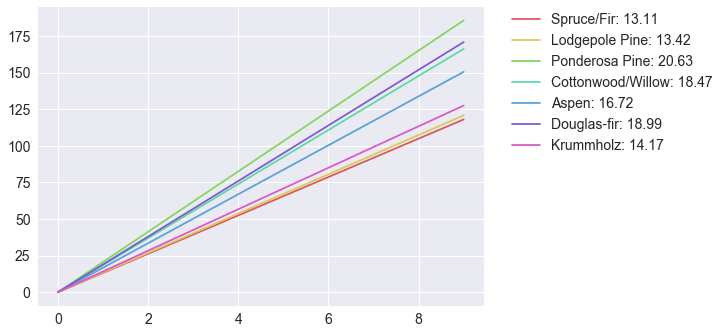

In [20]:
s = train[['Slope', 'Cover_Type']] \
    .groupby('Cover_Type') \
    .mean()

x = np.arange(0, 10, 1)
for i, slope in enumerate(s['Slope']):
    legend_label = cover_labels[i] + ': ' + str(round(slope, 2))
    plt.plot(x, [slope * i for i in x], rgb_values[i], label=legend_label)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('')

#### Hillshade

Hillshade is a feature that provides the hypothetical illumination of a surface at a particular time of day. It is computed using aspect, slope, and the height and angular direction of the sun (also known as altitude and azimuth respectively). In short, the formula to derive this shaded value is defined as:

```
Hillshade = 255.0 * ( ( cos(Zenith_rad) * cos(Slope_rad) ) + 
            ( sin(Zenith_rad) * sin(Slope_rad) * cos(Azimuth_rad - Aspect_rad) ) )
```

where 

```
Zenith_rad = (90 - Altitude) * pi / 180
```

Since hillshade represents the luminance of the forest ground, its output range varies in different shades of gray from white (0) to black (255). 

We noticed from the histogram above that there might potentially be some missing values in hillshade because of its differing distributions. We first determined if there are any missing values in hillshade. 

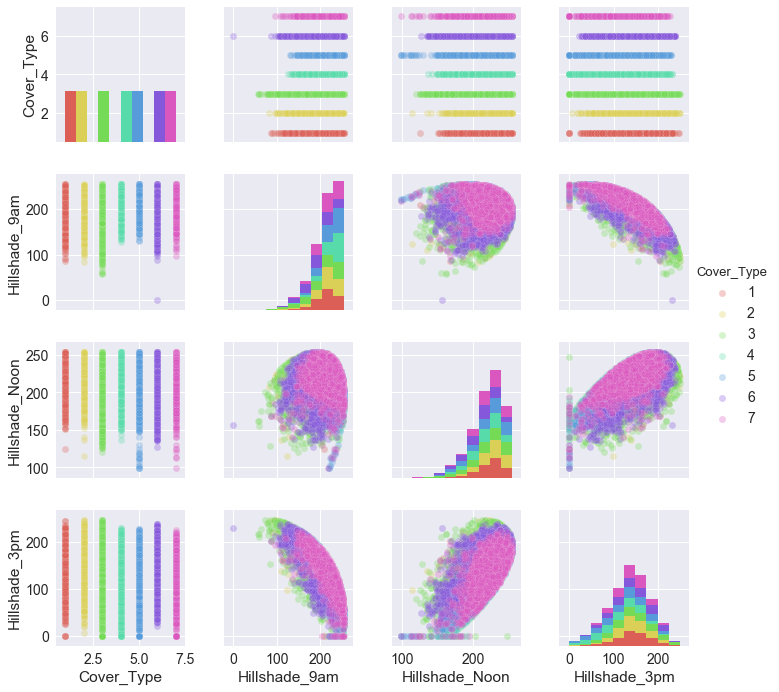

In [43]:
sns.pairplot(train[['Cover_Type'] + hillshade_vars], hue='Cover_Type', hue_order=cover_types, palette='hls',
             plot_kws={'alpha': 0.3});

['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']


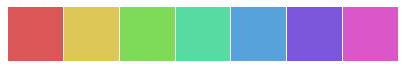

In [24]:
# specify legend
rgb_values = sns.hls_palette(7, 10).as_hex()
sns.palplot(sns.color_palette(rgb_values))
print(cover_labels)

There are three details to note in the relationship graph above: 

1. First, there are multiple zero values in Hillshade_3pm columns, represented as a linear line at zero in the Hillshade_9am vs Hillshade_3pm graph and in the Hillshade_Noon vs Hillshade_3pm graph. 
2. Second, Hillshade_9am and Hillshade_Noon seem to fall short of a normal distribution, which is understandable because a bright spot cannot get any more bright than white and a dark spot cannot get any more dark than black.
3. Like elevation, hillshade is a good determinant of the different forest cover types because of the lack of overlap. 

Before we verify that the given hillshade is the same as the one we computed, let us validate that Hillshade_9am and Hillshade_Noon have missing values due to the color range constraint from 0 to 255.

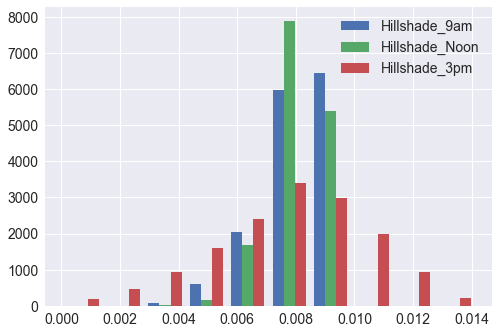

In [25]:
plt.hist(normalize(train_data[hillshade_vars], axis=0))
plt.legend(labels=hillshade_vars);

From the overlay of the normalized data above, it seems that the constraint in the color range does cause it to have missing values. During the feature engineering section, we will address the missing zeroes in Hillshade_3pm as well as the missing values that result from the color constraint. 

After computing the hillshade value using the slope and aspect values (as shown below), we come to realize that altitude and azimuth is highly dependent on the latitude and longitude of the location as well as the time of day. Also, altitude is not the same as elevation since elevation refers to the height above sea level while altitude refers to sun's angle up from the horizon (azimuth is the sun's angle along the horizon). 

In [26]:
# azimuth and altitude of the sun in Denver, Colorado 7/15/1998
# [9AM, 12PM, 3PM]
azimuth = [90.2, 137.6, 241.5]
altitude = [35.2, 67.0, 59.6]

# just check Hillshade at 9 AM
zenith_deg = 90 - altitude[0]
zenith_rad = zenith_deg * np.pi / 180
azimuth_math = 360 - azimuth[0] + 90
azimuth_rad = azimuth_math * np.pi / 180
slope_rad = train_data['Slope'] / 57.29578
aspect_rad = train_data['Aspect'] / 57.29578
hillshade = 255 * ((np.cos(zenith_rad) * np.cos(slope_rad)) + 
            (np.sin(zenith_rad) * np.sin(slope_rad) * np.cos(azimuth_rad - aspect_rad)))
# print comparison for the first 5
pd.DataFrame(hillshade, train_data['Hillshade_9am'])[0:5]

0
Hillshade_9am            
221            196.563086
220             97.514238
234            170.641898
238            187.459247
220             97.514238

#### Horizontal and Vertical Distance to Hydrology

Both horizontal and vertical distance to hydrology fall prey to few number of very large marginal outliers. For this reason, it would be apt in the feature engineering section to apply robust scaling onto the distribution since this scaler is scaled based on percentiles and therefore are not as heavily influenced to these outliers.

In addition, for vertical distances, there are several negative values. It might be a good idea to shift it to positive values by adding the smallest value in the feature column: 146. 

Lastly, to reduce the number of features, we would use the euclidean distance of the two in order to capture the two features as one.

In [161]:
np.min(train_data['Vertical_Distance_To_Hydrology'])

-146

#### Horizontal Distance to Roadways and Firepoints

Unlike the distances to hydrology, the horizontal distance to roadways and firepoints have less overlap. They still can derive benefit from scaling due to their positively skewed distributions.

#### Distances

Looking at all the distance features together through a parallel plot, we can see that Spruce/Fir cover type is similar to Lodgepole Pine. Again we see similarity between another two forest cover types: Ponderosa Pine and Douglas Fir. Cottonwood/Willow, Aspen, and Krummholz appear quite distinct from the rest, making distances promising features to add into our classifier model.

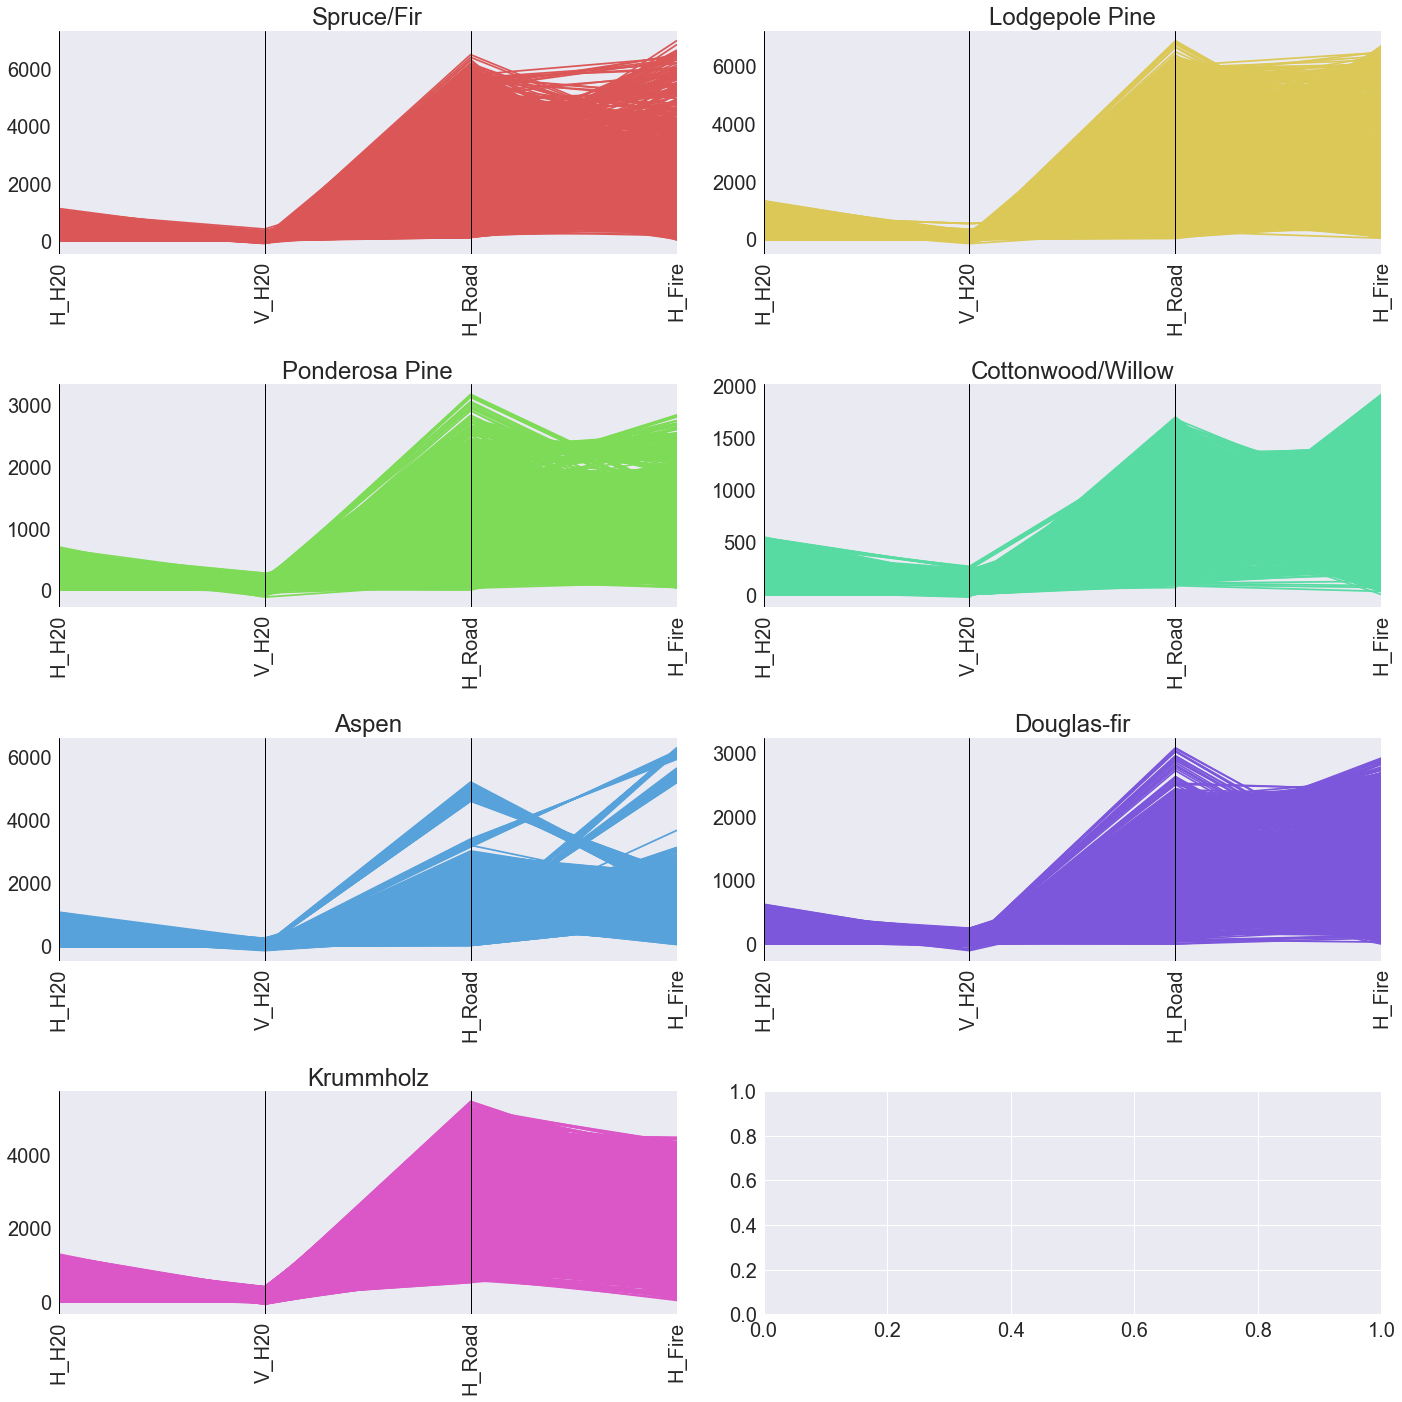

In [140]:
ncols = 2
nrows = len(cover_types)//2 + 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize = (20, 20))

for plot_index, (cover_type, cover_label) in enumerate(zip(cover_types, cover_labels)):
    row_index = plot_index//2
    col_index = plot_index - (2 * row_index)
    axis = axes[row_index, col_index]
    parallel_coordinates(train[train['Cover_Type'] == cover_type][['Cover_Type'] + distance_vars], 'Cover_Type',
                        color=rgb_values[cover_type - 1], ax=axis)
    axis.set_xticklabels(labels=['H_H20', 'V_H20', 'H_Road', 'H_Fire'], rotation=90)
    axis.legend_.remove()
    axis.set_title(cover_label)

fig.tight_layout()
plt.show()

#### Wilderness Areas

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-106.98949999999999,39.769400000000005,-104.98949999999999,41.7694&bboxSR=4269&imageSR=4269&size=2000,2000&dpi=96&format=png32&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-106.8325,39.5228,-104.8325,41.5228&bboxSR=4269&imageSR=4269&size=2000,2000&dpi=96&format=png32&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-106.6459,39.583,-104.6459,41.583&bboxSR=4269&imageSR=4269&size=2000,2000&dpi=96&format=png32&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-105.60080000000002,39.4213,-103.60080000000002,41.4213&bboxSR=4269&imageSR=4269&size=2000,2000&dpi=96&format=png32&f=image


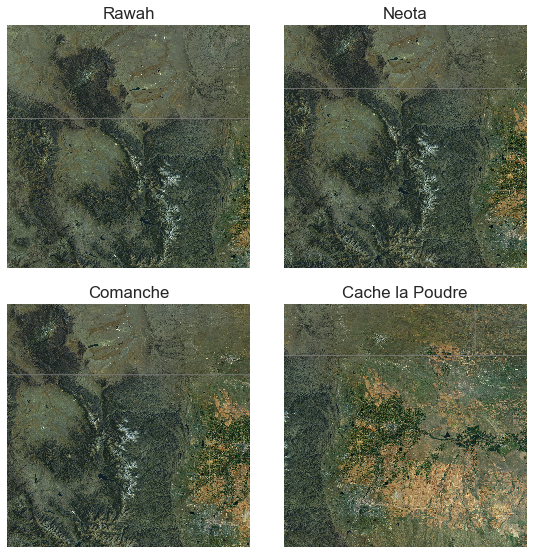

In [39]:
coords = {'Rawah': dict(lat = 40.7694, lon = -105.9895),
          'Neota': dict(lat = 40.5228, lon = -105.8325),
          'Comanche': dict(lat = 40.5830, lon = -105.6459),
          'Cache la Poudre': dict(lat = 40.4213, lon = -104.6008)
         }
               
def plot_basemap(wilderness_label, axis):
    # setup Lambert Conformal basemap
    #m = Basemap(projection='lcc', resolution='h', 
    #            lat_0=coords[wilderness_label]['lat'], lon_0=coords[wilderness_label]['lon'], 
    #            width=1E6, height=1E6, ax=axis)
    # draw a shaded relief
    #m.shadedrelief()
    # draw an etopo relief image 
    #m.etopo()
    # draw nasa blue marble image
    #m.bluemarble()

    # setup ARCGIS basemap
    m = Basemap(llcrnrlat=coords[wilderness_label]['lat']-1,
                llcrnrlon=coords[wilderness_label]['lon']-1,
                urcrnrlat=coords[wilderness_label]['lat']+1, 
                urcrnrlon=coords[wilderness_label]['lon']+1,
                epsg=4269, ax=axis)
    m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=2000, verbose=True)

    # draw body of water as a gray line
    m.drawcoastlines(color='gray')
    # draw state borders as a gray line
    m.drawstates(color='gray')
    # set title
    axis.set_title(wilderness_label)

ncols = 2
nrows = len(wilderness_vars)//2
fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize = (8,8))

for plot_index, wilderness_label in enumerate(wilderness_labels):
    row_index = plot_index//2
    col_index = plot_index - (2 * row_index)
    plot_basemap(wilderness_label, axes[row_index, col_index])

fig.tight_layout()
plt.show();

Based on wilderness area, we noted that:

* Spruce/Fir (1) is located in Rawah (1), Comanche (3), and Neota (2) in descending number of cover types
* Lodgepole Pine (2) is located in all wilderness area, with the most notable in Rawah (1) and Comanche (2)
* Ponderosa Pine (3) is located in Cache la Poudre(4) and Comanche (3)
* Cottonwood/Willow (4) is located only in Cache la Poudre (4)
* Aspen (5) is located in Comanche (3) and Rawah (1) 
* Douglas-fir (6) is located in Cache la Poudre (4) and Comanche (3)
* Krummholz (7) is located in Comanche (3), Rawah (1) and Neota (2)

For this reason, wilderness area is a substantial feature to use to determine a cover type.

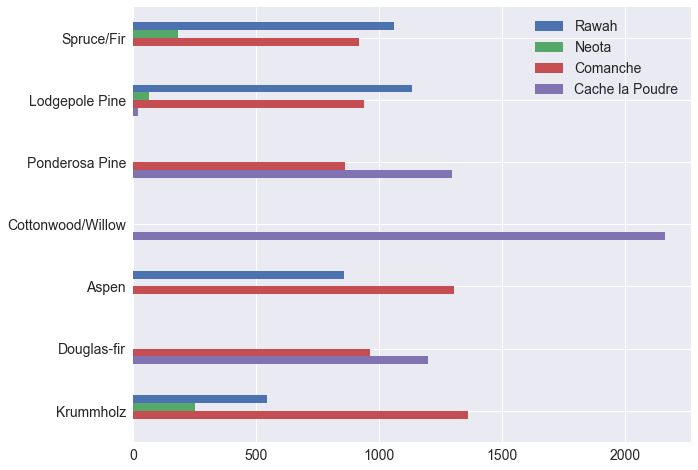

In [38]:
freq_ct_wilderness_1 = pd.crosstab(train_data['Wilderness_Area1'], train_labels).iloc[1].tolist()
freq_ct_wilderness_2 = pd.crosstab(train_data['Wilderness_Area2'], train_labels).iloc[1].tolist()
freq_ct_wilderness_3 = pd.crosstab(train_data['Wilderness_Area3'], train_labels).iloc[1].tolist()
freq_ct_wilderness_4 = pd.crosstab(train_data['Wilderness_Area4'], train_labels).iloc[1].tolist()
freq_ct_wilderness = pd.DataFrame([freq_ct_wilderness_1, freq_ct_wilderness_2, freq_ct_wilderness_3, freq_ct_wilderness_4], 
                                  columns=cover_labels, 
                                  index=wilderness_labels)
freq_ct_wilderness.T.plot(kind='barh', stacked=False,figsize=(10,8)).invert_yaxis();

#### Soil

During our analysis, we ignore soil type 7 and 15 because these soil types are absent in our sample.

In [44]:
print(pd.unique(train['Soil_Type7']))
print(pd.unique(train['Soil_Type15']))

[0]
[0]


As you can see below, each cover type sits on a broad range of soils. In addition, there seems to be repeated types of soil separated into multiple categories. For this reason, during our feature engineering phase, we will consider performing principal component analysis to reduce the number of features.

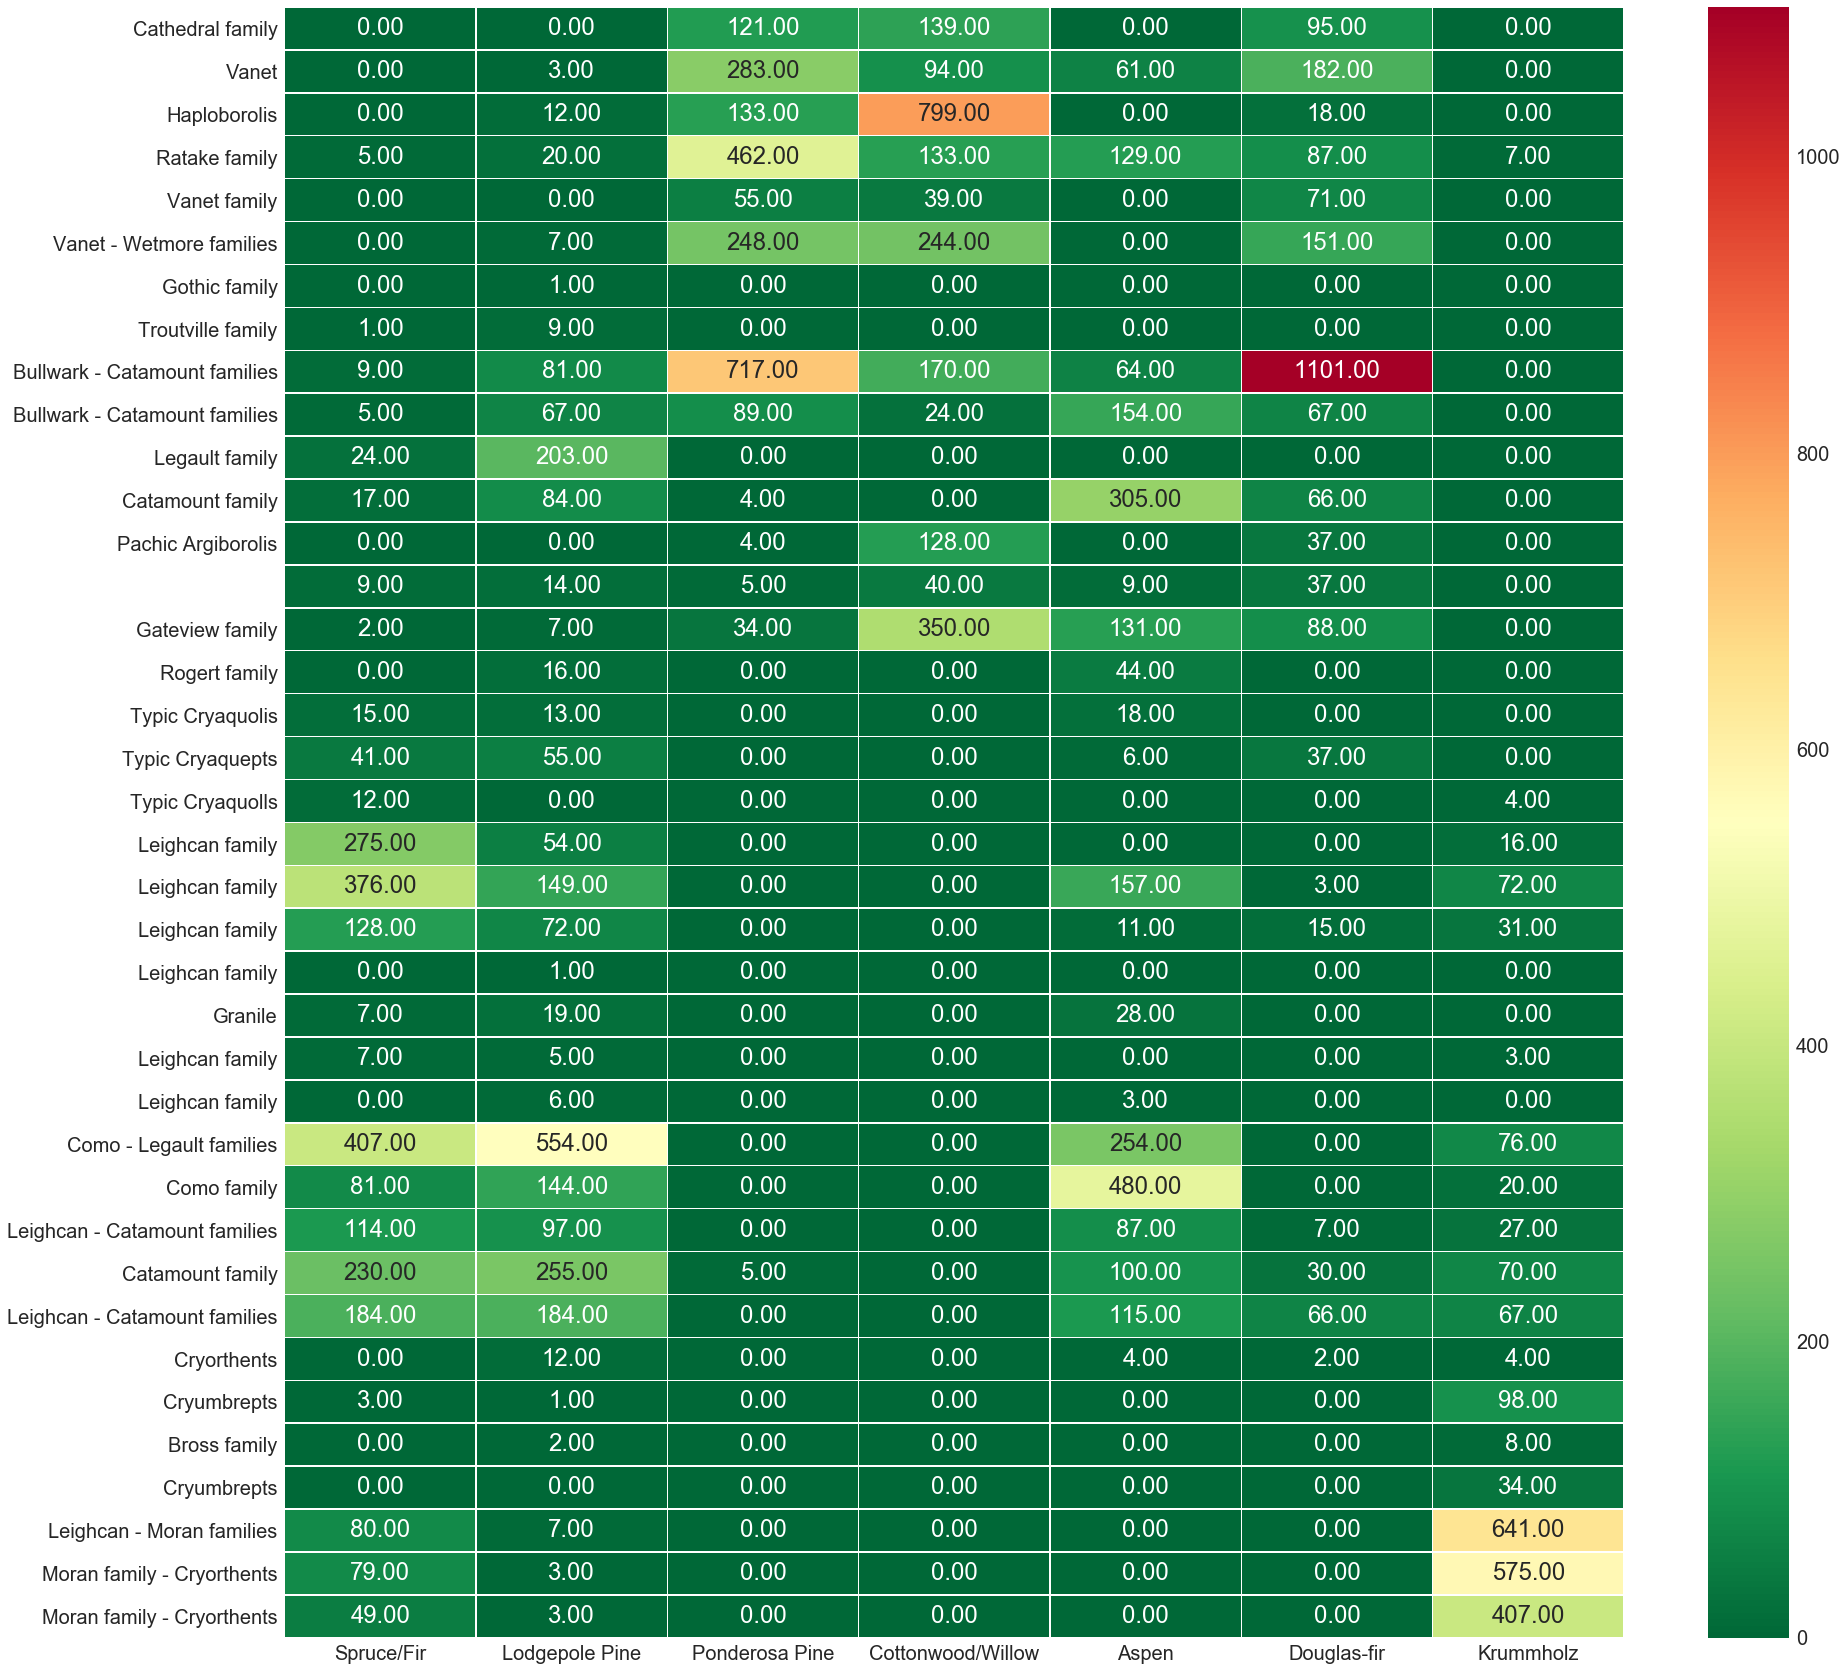

In [52]:
list_freq_ct_wilderness = []
for i in soil_types:
    # ignore soil type: 7, 15
    if i not in (7, 15):
        soil_type = 'Soil_Type{}'.format(i)
        pd.crosstab(train[soil_type], train['Cover_Type']).iloc[1].tolist()
        list_freq_ct_wilderness.append(pd.crosstab(train[soil_type], train['Cover_Type']).iloc[1].tolist())

soil_labels_wo_7_15 = [soil_label for ignore_label, soil_label in enumerate(soil_labels) if ignore_label not in [7,15]]
freq_ct_soil = pd.DataFrame(list_freq_ct_wilderness, 
                            columns=cover_labels, 
                            index=soil_labels_wo_7_15)

plt.figure(figsize=(30,30))
sns.set(font_scale=2)
fig = sns.heatmap(freq_ct_soil, annot=True, cmap='RdYlGn_r', fmt='.2f', linewidth=0.5)

<a id='bivariate-analysis' />

### Bivariate Analysis

We plot a scatterplot matrix with the diagonal showing the Kernel Density Estimation and a correlation matrix to see if any variables are correlated with each other. Correlated variables do not always worsen the model but they do not improve it either. We would like to minimize the number of correlated features used so that we can prevent harmful bias and enable our model to learn much faster.

What we noticed are the following potential correlations:

1. **Horizontal and Vertical Distance To Hydrology**: It is understandable that they are quite related to one another. A simple convergence with the Euclidean distance will ensure that the two features are included in the model without a potential problem of correlation.
2. **Hillshades**: Hillshades found at different times also appear to be quite related to one another. One way we can solve this potential issue is to take their mean value once the data are normalized and imputted for missing values.
3. **Aspect and Slope with Hillshade**: With hillshade deriving its value from the aspect and slope of the ground, it might be fitting to hold on to hillshade and potential forego aspect and slope since hillshade contains information in regards to the position of the sun.
4. **Elevation, Horizontal Distance to Roadways and Fire Points**: The higher the elevation, the potential for a forest to get burned. The lower the elevation, the closer the roadways might be to the forest. These are the assumptions we can deduce from the correlation, but without having additional background knowledge, it becomes challenging to validate these assumptions or reduce these three features into one as we did in the previous suggestions made above. 

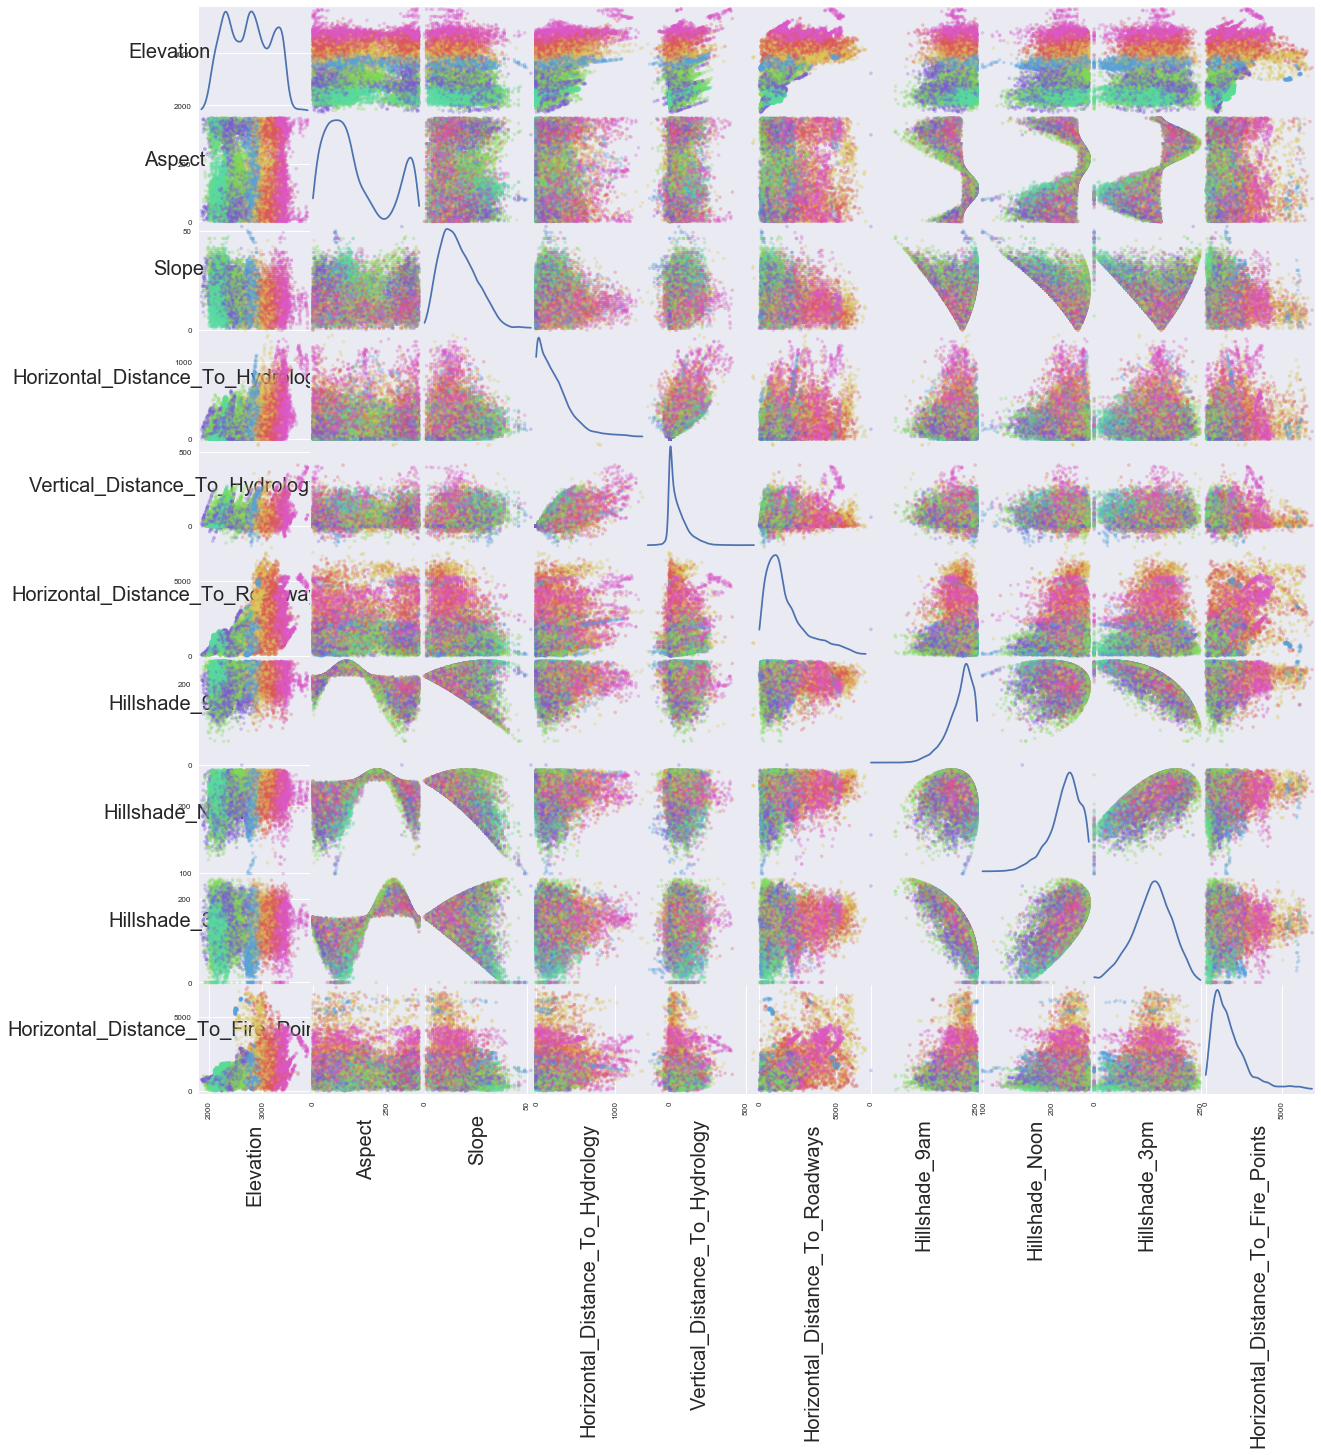

In [100]:
sm = scatter_matrix(train[numerical_vars], 
               diagonal='kde',
               color=train['Cover_Type'].apply(lambda x: rgb_values[x-1]),
               alpha=0.3, 
               figsize=(20,20));
for ax in sm.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize='small', rotation=90)
    ax.set_ylabel(ax.get_ylabel(), fontsize='small', rotation=0)

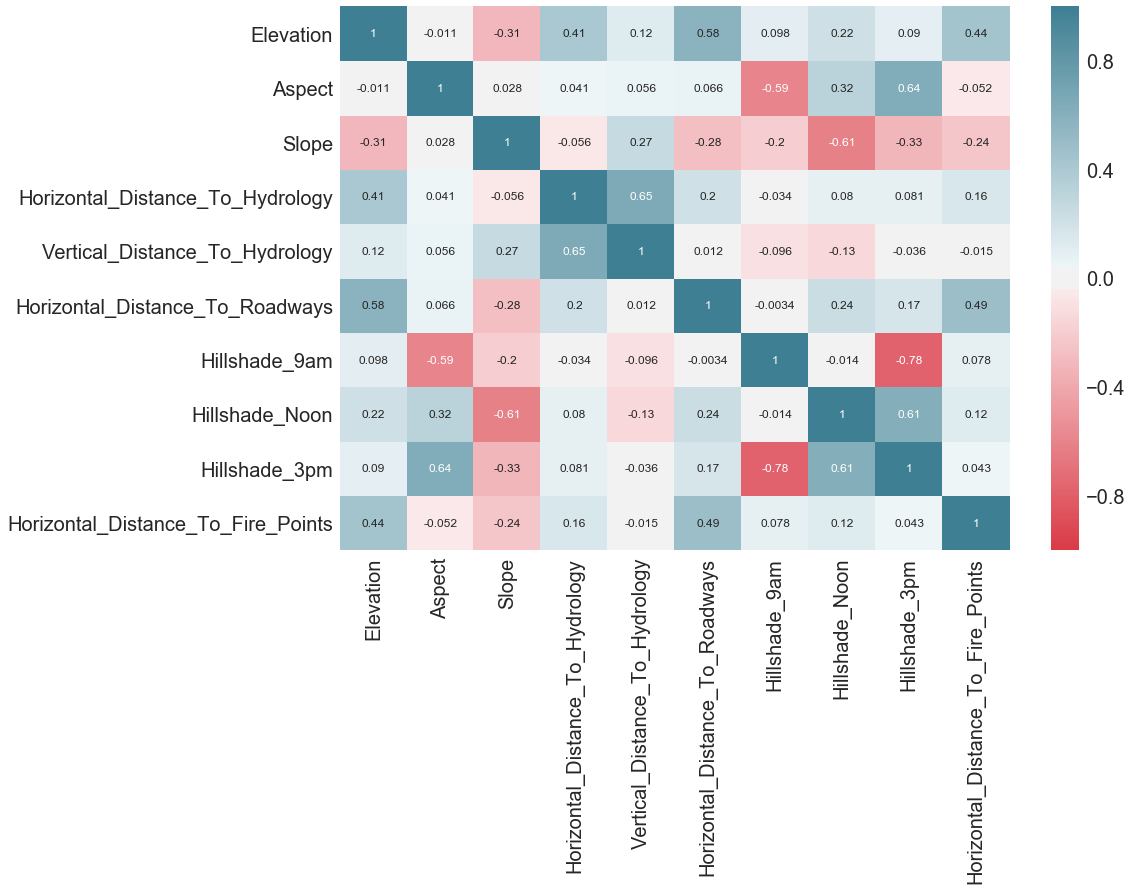

In [148]:
plt.figure(figsize=(15,10))
sns.heatmap(train_data[numerical_vars].corr(), annot=True, annot_kws={"size": 12},
            cmap=sns.diverging_palette(10, 220, as_cmap=True));

<a id='feature-engineering' />

## Feature Engineering

Without any feature engineering in place, we have found that Random Forest Classifier performs better than the other models we have tested in classifying the forest cover types. For that reason, we have decided to use Random Forest Classifier as the baseline to compare any feature transformation. 

The features that we ultimately included in our model are:

1. Elevation, scaled with a RobustScaler
2. Aspect
3. Slope
4. Euclidean_Distance_To_Hydrology, scaled with a RobustScaler
5. Horizontal_Distance_To_Roadways, scaled with a RobustScaler
6. Horizontal_Distance_To_Fire_Points, scaled with a RobustScaler
7. Wilderness_Area 1-4
8. Soil_Type 1-40, except for soil type 7 and 15 since none of the observations include them.
9. Log of Horizontal_Distance_To_Roadways
10. Log of Horizontal_Distance_To_Fire_Points

Features related to distances are scaled so that the algorithm used in our model will not be blindsided by the magnitude of the features. In addition, we took the log transformation of the horizontal distance to roadways and fire points to help make the highly skewed distributions less skewed. 



* fill zero hillshade 3 pm
*  DONE --- fill hillshade 9 am and 12 pm --> just normalize it
*  DONE --- once hillshade is normalized, take the mean of the values
* just use hillshade instead of aspect and slope
* pca on soil 


<a id='features-not-included' />

### Features Not Included

There are several reasons why feature transformations ended up not being included. The main reason is that it did not improve the accuracy of the model. For example, we did not include the squared transformation of elevation even though we thought squaring it will account for the polynomial shape in the distribution. Similarly, even though our analysis shown that grouping aspect by its compass direction helps to visually determine the likelihood of the forest cover type, it also did not improve the model.

What makes it challenging is to not incorporate a feature into the final model, like hillshade for example. It turns out that most of its features are already explained by aspect and slope. And the components that differentiate hillshade from aspect and slope--altitude and azimuth of the sun--did not pose a substantial impact in differentiating the forest cover types.

As discussed in the EDA section, we fill the zeroes in Hillshade_3pm. We also attempted to fill the missing half of the distribution in Hillshade_9am and Hillshade_Noon but decided against it because we could not account for the percentage of observations that ended up being at the lowest and highest tail of the distribution 

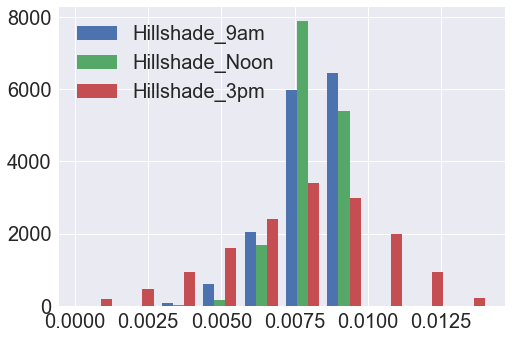

In [282]:
plt.hist(normalize(train_data[hillshade_vars], axis=0))
plt.legend(labels=hillshade_vars);

In [18]:
import scipy.stats as st
args = st.norm.fit(train_data['Hillshade_3pm'])
# Kolmogorov-Smirnov test to assess goodness of fit of the distribution with respect to the data
st.kstest(train_data['Hillshade_3pm'], st.norm.cdf, args)
# very low p-value, not a good fit

KstestResult(statistic=0.03615391431985915, pvalue=1.3637289423715014e-17)

In [193]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian')
kde.fit(train_data['Hillshade_3pm'].values.reshape(-1, 1))

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [ ]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian')
kde.fit(train_data['Hillshade_3pm'].values.reshape(-1, 1))

x = train_data['Hillshade_3am'].values.reshape(-1, 1)
y = kde.score_samples(x)
sns.distplot(x)
sns.distplot(y)
plt.show()

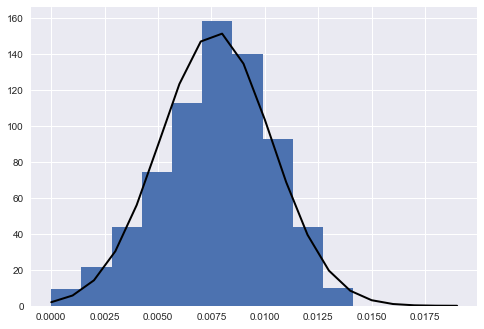

In [265]:

norms = normalize(train_data[hillshade_vars], axis=0)
norm_9am = norms[:,0]
norm_12pm = norms[:,1]
norm_3pm = norms[:,2]
from scipy.stats import norm
mu, std = norm.fit(norm_3pm)
plt.hist(norm_3pm, density=True)
plt.plot(np.arange(0, 0.02, 0.001), norm.pdf(np.arange(0, 0.02, 0.001), mu, std), 'k', linewidth=2)

In [288]:
mu_9am = np.mean(norm_9am) 

In [289]:
sd_9am = np.std(norm_9am)

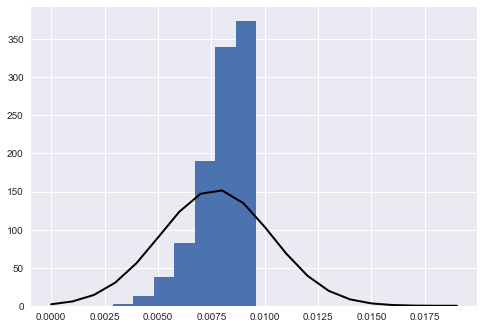

In [291]:
plt.hist(norm_9am, density=True)
plt.plot(np.arange(0, 0.02, 0.001), norm.pdf(np.arange(0, 0.02, 0.001), mu, std), 'k', linewidth=2)

In [277]:
np.min(norm_12pm[np.nonzero(norm_12pm)])

0.0036571389266477987

In [278]:
mu_12pm = mu + np.min(norm_12pm[np.nonzero(norm_12pm)])

In [272]:
sd_12pm= np.std(norm_12pm)

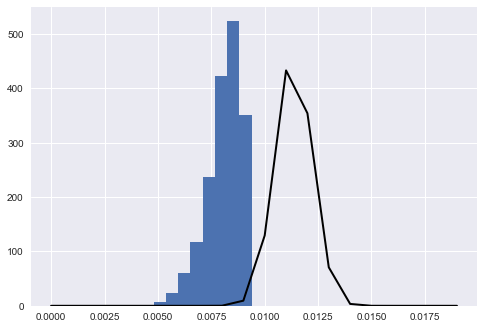

In [279]:
plt.hist(norm_12pm, density=True)
plt.plot(np.arange(0, 0.02, 0.001), norm.pdf(np.arange(0, 0.02, 0.001), mu_12pm, sd_12pm), 'k', linewidth=2)

Problem with so many variables:
* not understanding the relationships between each variable
* danger of overfitting the model
* violate assumptions

* goal: reduce dimension of your feature space

Do you want to reduce the number of variables, but aren’t able to identify variables to completely remove from consideration?

Do you want to ensure your variables are independent of one another?

Are you comfortable making your independent variables less interpretable?

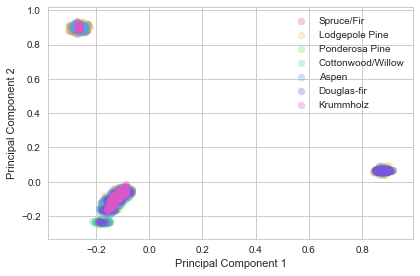

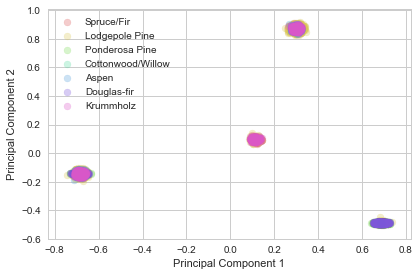

In [191]:
pca = PCA(n_components=2)

def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# can categorical variable soil benefit from PCA? Potentially yes
soil_pca_data = pca.fit_transform(train_data[soil_vars])
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(set(train_labels), rgb_values):
        plt.scatter(rand_jitter(soil_pca_data[train_labels==lab, 0]),
                    rand_jitter(soil_pca_data[train_labels==lab, 1]),
                    label=lab,
                    c=col, alpha=0.3)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(labels=cover_labels)
    plt.tight_layout()
    plt.show()

# can categorical variable soil benefit from PCA? No
wilderness_pca_data = pca.fit_transform(train_data[wilderness_vars])
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(set(train_labels), rgb_values):
        plt.scatter(rand_jitter(wilderness_pca_data[train_labels==lab, 0]),
                    rand_jitter(wilderness_pca_data[train_labels==lab, 1]),
                    label=lab,
                    c=col, alpha=0.3)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(labels=cover_labels)
    plt.tight_layout()
    plt.show()

In [ ]:
s_train_data, s_dev_data, s_train_labels, s_dev_labels = train_test_split(fe_train_data, train_labels, stratify=train_labels, test_size=0.2, random_state=random_state)
def P5(pca_n_components=2, gmm_n_components=4, gmm_covariance_type='full'):
### STUDENT START ###

    pca = PCA(n_components=pca_n_components)
    pca_fit = pca.fit(train_data)
    pca_train_data = pca.transform(train_data)
    pca_test_data = pca.transform(test_data)
    
    # fit 4-component full covariance GMM for positive examples (poisonous)
    pca_train_data_pos = pca_train_data[train_labels == 1]
    gmm_pos = GaussianMixture(n_components=gmm_n_components, covariance_type=gmm_covariance_type)
    gmm_pos.fit(pca_train_data_pos)
            
    # fit 4-component full covariance GMM for negative examples (non-poisonous)
    pca_train_data_neg = pca_train_data[train_labels == 0]
    gmm_neg = GaussianMixture(n_components=gmm_n_components, covariance_type=gmm_covariance_type)
    gmm_neg.fit(pca_train_data_neg)
    
    # compute the weighted log probabilities for each observation in the test dataset
    log_prob_pos = gmm_pos.score_samples(pca_test_data) # predicted log probability with positive classifier
    log_prob_neg = gmm_neg.score_samples(pca_test_data) # predicted log probability with negative classifier
    
    # predict whether the mushroom is poisonous if the probability predicted by the positive classifier 
    # was greater than the probability predicted by the negative classifier 
    pred_labels = np.array(log_prob_pos > log_prob_neg).astype(int)

    # print out the accuracy     
    return np.round(np.mean(pred_labels == test_labels), 4)
    
### STUDENT END ###

P5()

def P6(max_params=50):
### STUDENT START ###

    def get_num_params(pca_n_components, gmm_n_components, gmm_covariance_type, num_classes=len(cover_types)):
        is_tied = 0
        if cov_type == 'full':
            cov_params = (pca_n_components * (pca_n_components + 1)) / 2
        elif cov_type == 'spherical':
            cov_params = 1
        elif cov_type == 'diag':
            cov_params = pca_n_components
        elif cov_type == 'tied':
            cov_params = 0
            is_tied = 1
        return ((pca_n_components + cov_params) * gmm_n_components + 
                (pca_n_components * (pca_n_components + 1)) / 2 * is_tied) * num_classes

        # define the output variables to print out
        output_columns = ['PCA n_components', 
                          'GMM n_components', 
                          'GMM covariance_type', 
                          'num_params',
                          'accuracy']
        output = pd.DataFrame(columns=output_columns)
    
    # define the index of the output that will increment as a new row is added
    i = 0
    
    for pca_n_components in range(1, int(max_params/2)):
        for gmm_n_components in range(1, int(max_params/2)):
            # purposely not specifying tied because unsure how to compute its param numbers
            for gmm_covariance_type in ['spherical', 'diag', 'full', 'tied']: 
                num_params = get_num_params(pca_n_components, gmm_n_components, gmm_covariance_type)
                if num_params <= max_params: 
                    accuracy = P5(pca_n_components, gmm_n_components, gmm_covariance_type)
                    output.loc[i] = [pca_n_components,
                                     gmm_n_components,
                                     gmm_covariance_type,
                                     num_params,
                                     accuracy]
                    i = i + 1
    
    # print the first 10 output in descending order by highest accuracy
    print(output.sort_values(by=['accuracy'], ascending=False)[:11])
    
### STUDENT END ###

P6()

<a id='baseline-test'/>

### Define the baseline test

In [350]:
# employ a baseline model for comparison
def compare_baseline(data, labels,clf=None):
    BASELINE_MEAN = 0.7762
    BASELINE_SD = 0.0412
    if clf == None:
        clf = RandomForestClassifier(n_estimators=50, max_depth=76, random_state=random_state)
    scores = cross_val_score(clf, data, labels, cv=10)
    if np.mean(scores) > BASELINE_MEAN:
        print('Improve')
    else:
        print('Worsen')
    print('mean = {} ({})'.format(round(np.mean(scores), 4), BASELINE_MEAN))
    print('sd = {} ({})'.format(round(np.std(scores), 4), BASELINE_SD))

<a id='fe-functions'/>

### Define functions to be used in the pipeline

In [309]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_union
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import math

class SelectFeatures(BaseEstimator, TransformerMixin):
    """Select the features"""
    
    def __init__(self, columns):
        self.columns = columns
   
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        return X[self.columns]
    
class Square(BaseEstimator, TransformerMixin):
    """Square the feature"""
    
    def __init__(self,column):
        self.column = column
   
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        return pd.DataFrame(X[self.column]**2 )

class Log(BaseEstimator, TransformerMixin):
    """Log the feature"""
    
    def __init__(self,column):
        self.column = column
   
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        return pd.DataFrame(np.log(X[self.column] + 1))

    
class Mean(BaseEstimator, TransformerMixin):
    """Mean the features"""
    
    def __init__(self,columns):
        self.columns = columns
   
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        return pd.DataFrame(np.mean(X[self.columns], axis=1))

class GroupAspect(BaseEstimator, TransformerMixin):
    """Group Aspect to 8 different compass direction"""
    
    def __init__(self,column):
        self.column = column
   
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        # group by Aspect's compass direction
        # North: [354+3/8, 5+5/8)
        # NE:    [5+5/8, 84+3/8)
        # East:  [84+3/8, 95+5/8)
        # SE:    [95+5/8, 174+3/8)
        # South: [174+3/8, 185+5/8)
        # SW:    [185+5/8, 264+3/8)
        # West:  [264+3/8, 275+5/8)
        # NW:    [275+5/8, 354+3/8)
        #aspect_types = [1, 2, 3, 4, 5, 6, 7, 8]
        #aspect_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
           
        ag_n = []
        ag_ne = []
        ag_e = []
        ag_se = []
        ag_s = []
        ag_sw = []
        ag_w = []
        ag_nw = []

        for a in X[self.column]:
            if (354+3/8 <= a <= 360) or (0 <= a < 5+5/8):
                ag_n.append(1)
                ag_ne.append(0); ag_e.append(0); ag_se.append(0); ag_s.append(0); ag_sw.append(0); ag_w.append(0); ag_nw.append(0)
            elif(5+5/8 <= a < 84+3/8):
                ag_ne.append(1)
                ag_n.append(0); ag_e.append(0); ag_se.append(0); ag_s.append(0); ag_sw.append(0); ag_w.append(0); ag_nw.append(0)
            elif(84+3/8 <= a < 95+5/8):
                ag_e.append(1)
                ag_ne.append(0); ag_n.append(0); ag_se.append(0); ag_s.append(0); ag_sw.append(0); ag_w.append(0); ag_nw.append(0)
            elif(95+5/8 <= a < 174+3*8):
                ag_se.append(1)
                ag_ne.append(0); ag_e.append(0); ag_n.append(0); ag_s.append(0); ag_sw.append(0); ag_w.append(0); ag_nw.append(0)
            elif(174+3/8 <= a < 185+5/8):
                ag_s.append(1)
                ag_ne.append(0); ag_e.append(0); ag_se.append(0); ag_n.append(0); ag_sw.append(0); ag_w.append(0); ag_nw.append(0)
            elif(185+5/8 <= a < 264+3/8):
                ag_sw.append(1)
                ag_ne.append(0); ag_e.append(0); ag_se.append(0); ag_s.append(0); ag_n.append(0); ag_w.append(0); ag_nw.append(0)
            elif(264+3/8 <= a < 275+5/8):
                ag_w.append(1)
                ag_ne.append(0); ag_e.append(0); ag_se.append(0); ag_s.append(0); ag_sw.append(0); ag_n.append(0); ag_nw.append(0)
            elif(275+5/8 <= a < 354+3/8):
                ag_nw.append(1)
                ag_ne.append(0); ag_e.append(0); ag_se.append(0); ag_s.append(0); ag_sw.append(0); ag_w.append(0); ag_n.append(0)

        return pd.DataFrame({'Aspect_N': ag_n, 
                             'Aspect_NE': ag_ne, 
                             'Aspect_E': ag_e, 
                             'Aspect_SE': ag_se, 
                             'Aspect_S': ag_s, 
                             'Aspect_SW': ag_sw, 
                             'Aspect_W': ag_w, 
                             'Aspect_NW': ag_nw})
    
class ModelTransformer(BaseEstimator, TransformerMixin):
    """Transform model for stacking purposes"""

    def __init__(self, model):
        self.model = model

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return pd.DataFrame(self.model.predict_proba(X))


<a id='fe-features'/>

### Define features to be used in the pipeline

In [164]:
# make a copy of the train data to be modified
fe_train_data = train_data.copy()

# remove soil 7 and 15
soil_vars_to_remove = ['Soil_Type7', 'Soil_Type15']
fe_train_data.drop(soil_vars_to_remove, axis=1, inplace=True)

# Vertical_Distance_To_Hydrology -> positive
min_vdisth20 = np.min(train_data['Vertical_Distance_To_Hydrology'])
fe_train_data['Vertical_Distance_To_Hydrology'] = \
    fe_train_data.apply(lambda row: row['Vertical_Distance_To_Hydrology'] + (-1 * min_vdisth20), axis=1)

# define Euclidean_Distance_To_Hydrology
fe_train_data['Euclidean_Distance_To_Hydrology'] = \
    np.sqrt(fe_train_data['Horizontal_Distance_To_Hydrology']**2 + fe_train_data['Vertical_Distance_To_Hydrology']**2)

# drop Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology
fe_train_data.drop(['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'], axis=1, inplace=True)

# Hillshade means
fe_train_data['Hillshades_Mean'] = np.mean(normalize(train_data[hillshade_vars]), axis=1)

In [348]:
my_features = FeatureUnion([
    # --------------------------------------------------
    # Elevation
    # --------------------------------------------------
    ('scale_elevation', Pipeline([
        ('select', SelectFeatures(['Elevation'])),
        ('scale', RobustScaler())
        
    ])),    
    
    # --------------------------------------------------
    # Aspect 
    # --------------------------------------------------
    ('select_aspect', SelectFeatures(['Aspect'])),
    #('group_aspect', GroupAspect('Aspect')),
        
    # --------------------------------------------------
    # Slope 
    # --------------------------------------------------
    ('select_slope', SelectFeatures(['Slope'])),
    
    # --------------------------------------------------
    # Distances
    # --------------------------------------------------
    ('scale_distances', Pipeline([
        ('select', SelectFeatures(['Euclidean_Distance_To_Hydrology', 
                                   'Horizontal_Distance_To_Roadways',
                                   'Horizontal_Distance_To_Fire_Points'])),
        ('scale', RobustScaler())
    ])),       
    ('log_dist_road', Log('Horizontal_Distance_To_Roadways')),
    ('log_dist_fire', Log('Horizontal_Distance_To_Fire_Points')),
    
    # --------------------------------------------------
    # Hillshade
    # --------------------------------------------------
    #('select_hillshades_mean', SelectFeatures(['Hillshades_Mean'])), 
    
    # --------------------------------------------------
    # Wilderness Areas and Soil
    # --------------------------------------------------
    ('select_categoricals', SelectFeatures(
      list(  set(categorical_vars) - set(soil_vars_to_remove) )
    ))
]) 


In [349]:
# compare F.E. features with baseline model
pipeline = Pipeline([
    ('features', my_features),
    ('estimator', RandomForestClassifier(n_estimators=50, max_depth=76, random_state=random_state))
])

compare_baseline(fe_train_data, train_labels, pipeline)

Improve
mean = 0.7952 (0.7762)
sd = 0.0404 (0.0412)


<a id='final-model' />

## Final Model

Based on our intuition of the use case, the problem that we are trying to solve is a multi-class classification problem. We come to this conclusion because we are trying to fit 54 features (of cartographic information) into 7 classes (of forest cover types). For this reason, we will look into multi-class classification methods to see which model performs the best classification of the problem at hand. 

The multi-class classification methods that we have compared are:

1. Logistic Regression (LR): skip because of failure to converge on multiple occassion
2. Naive Bayes (NB)
3. K-Nearest Neighbors (KNN)
4. Support Vector Machine (SVM)
5. Decision Tree (DT)
6. Neural Network (NN)

with KNN and Decision Trees performing better than the other models (at an accuracy score above 75%). 

To determine which model predicts with the highest accuracy, we performed a cross-validation check using randomized search (RandomizedSearchCV). The reason why we chose cross-validation over train/test split is because cross-validation will create multiple train/test splits. The average accuracy resulted from each split provides a lower variance estimate compare to that of train/test split because accuracy changes drastically based on what is in the test set.

We also chose randomized search (RandomizedSearchCV) over grid search (GridSearchCV) to reduce the computational time. Unlike grid search, randomized search does not iterate over each parameter simulatenously, allowing us to have computational control at the cost of a slightly worse performance. 

To improve the accuracy of the models, we decided to combine several models and average their predictions. There are three ways to ensemble the models. One way, called the average methods, will build the models independently which will help in reducing the variance and therefore fine tuning the prediction to the expected outcome. In contrast, the second way, called the boosting methods, will build the models sequentially in order to reduce the bias of the combined estimators, improving the performance score. Lastly, the third way, called the voting methods, will act as a wrapper to the independently build models and average the predictions of the sub-models when making predictions. Voting is similar to stacking (discussed in the next section) minus the adding of the weights to the predictions of the sub-models.

In summary, ensembling build multiple models typically of the same type in order to reduce variance (average methods) and to reduce bias (boosting methods). It can also be used with models of different types (like in the case of the voting methods) in order to balance out their individual weaknesses.

The ensemble methods that we have looked at are:

(average methods) Bagged Decision Trees
(average methods) Random Forest
(average methods) Extra Trees
(boosting methods) Ada Boost
(boosting methods) Stochastic Gradient Boosting
(voting methods) Voting

with Random Forest and Stochastic Gradient Boosting further improving the score.

With more than 40 features, it does not seem realistic that we fit the entire feature set into one model type. For this reason, we take a look at stack modeling which generates a new model from multiple predictive models and find the following stack model to perform the best after multiple runs:

In [353]:
pipe = Pipeline([
    ('features', my_features),
    ('estimators', FeatureUnion([
        ('RF_clf', ModelTransformer(RandomForestClassifier(random_state= random_state))),
        ('knn'   , ModelTransformer(KNeighborsClassifier())),
        ('GB_CLF', ModelTransformer(GradientBoostingClassifier(random_state=random_state))),
    ])),
    ('estimator',  RidgeClassifier(alpha=10,random_state=random_state))
])

In [354]:
param_grid = dict(
     estimators__RF_clf__model__n_estimators            = [50,100,150], 
     estimators__RF_clf__model__max_depth               = [25,50,75,100],
     estimators__knn__model__n_neighbors                = [15,50,100,200],
     estimators__GB_CLF__model__n_estimators            = [50,100,200]
)

In [ ]:
rgrid = RandomizedSearchCV(pipe, param_grid, cv=10, scoring='accuracy', n_iter=10, verbose=1, n_jobs=-1)
rgrid.fit(fe_train_data, train_labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Predicting the test dataset

In [ ]:
rgrid.predict(test_data).hist(bins=50);

<a id='references'/>

## References
1. Bache, K. & Lichman, M. (2013). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science
2. “Colorado's Major Tree Species.” Colorado State Forest Service, csfs.colostate.edu/colorado-trees/colorados-major-tree-species/#1466527937174-cd5c5e60-5efc.
3. Slope, Aspect, and Hillshade.” GEOG 571: Intelligence Analysis, Cultural Geography, and Homeland Security, www.e-education.psu.edu/geog480/node/490.
4. https://www.fs.fed.us/rm/pubs_other/rmrs_2007_stage_a002.pdf
5. https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-hillshade-works.htm
6. http://aa.usno.navy.mil/cgi-bin/aa_altazw.pl?form=1&body=10&year=1998&month=7&day=15&intv_mag=10&state=CO&place=denver
7. http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
8. https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

<a id='appendix'/>

## Appendix